# **Determination of the cosmic muon lifetime and magnetic moment**
*Alberto Salvador, Giancarlo Saran Gattorno, Gaia Volpi*

## 1. Introduction

Cosmic muons are particles produced in the decays of pions ($\pi$) and kaons ($K$) originating from the interactions of primary cosmic rays with the nuclei in the Earth’s atmosphere. Being a point-like charged lepton that carries a unit electrical charge, with a spin of 1/2 and a mass of about 207 masses of the electron, the muon possesses a magnetic moment and so it can interact with external magnetic fields.

Muons decay via the weak interaction and so parity violation is present in these processes, which proceed as follows:

$\mu^{+} \rightarrow e^{+} + \nu_{e} + \bar{\nu}_{\mu} \ \ \text{and} \ \ \mu^{-} \rightarrow e^{-} + \bar{\nu_{e}} + {\nu}_{\mu}$

As a consequence of parity violation and the energy spectra of pions from which the muons are produced, there is a net polarization of cosmic muons, meaning that their spins have a preferred orientation.

The directions of the emitted $e^{+}$ ($e^{-}$) are correlated with the polarization of such muons as for the decays of positive muons, positrons are favorably emitted in the direction of the muon spin, while for the decays of negative muons, electrons are favorably emitted in the opposite direction of the muon spin. This leads to an asymmetric angular distribution of the positrons. 

This project is based on mesurements of muons that decay in a thick absorber at Earth’s surface. It is important to note that stopped $\mu^{-}$ in a target will be quickly cought by the nuclei, so we restrict ourselves to $\mu^{+}$. 
By putting the material in a known magnetic field, the spins of the stopped muons precess in it with the angular velocity  $\omega = g_{\mu} \ \dfrac{eB}{2m_{\mu}}$, where $g_{\mu}$ is the gyromagnetic ratio of the muon, $\ m_{\mu}$ and $e$ its mass and charge respectively.
By measuring the distribution of $e^{+}$ in a certain direction as a function of time, it is possible to determine the precession frequency of the muons and from this, its magnetic moment. The same distribution mesured without the presence of a magnetic field can instead be used to determine the muon lifetime.

When there is no magnetic field present, the data should follow a simple exponential dependence:
$$
I(t)=I_{0}e^{-t/\tau} + C
$$

where $I(t)$ is the number of muon decays in a unit of time at time $t$, $I_{0}$ is the decay rate at t=0, $\tau$ is the muon mean lifetime, and $C$ a constant due to the background. 

With an applied magnetic field the above relation is expected to become:
$$
I(t)=I_{0}e^{-t/\tau} \ [1 + \alpha \ cos \ (\omega t + \delta)]+ C
$$
where $\alpha$ is the experimental asymmetry (depending on on the asymmetry of the positrons emitted in the muon decays, the polarization of the stopped muons, and the geometry of the setup), $\omega$ is the muon precession frequency, and $\delta$ is the angle of initial muon polarization.

<hr style="border:2px solid gray">

## 2. Preliminary operations

In [3]:
library(DataCombine)
library(rjags)
library(coda)
library(ggplot2)
library(dplyr)
library(gridExtra)

options(repr.plot.width = 13, repr.plot.height = 7) 

For this analysis, we will use measurements of the time intervals between muon detection and the subsequent emission of positrons during decay. Our dataset is composed of a set of files, each epresenting one day of measurements, containing the time intervals measured for every event happened during that day. In particular, we have two types of data: measuments taken without the magnetic field and the ones taken with the magnetic field. We will refer as 'lifetime dataset' for the first and as 'precession dataset' for the latter.

Times are registered as multiple of the clock of the electronic measurement system. In order to convert them to seconds we used the following calibration line, measured on the apparatus using known signals:

<div style="text-align: center;">
  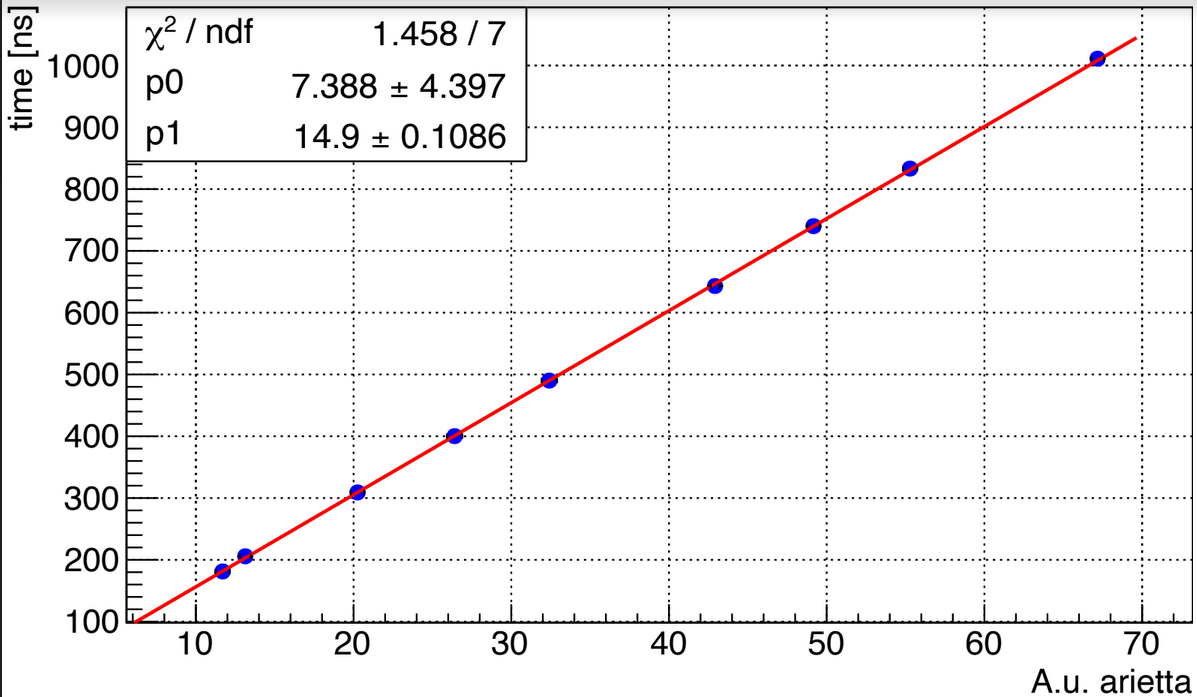
</div>

which follows the model $t_{seconds} = p_0 + p_1 * t_{ADC}$.

We will proceed by loading the data related to the different types of measurements into two separate dataframes. Then, we convert the times to micro-seconds.

In [4]:
# function to load the dataset in a single dataframe and to convert the mesurements from clock time to microseconds

data.loader <- function(path, verbose=F){
    files <- list.files(path=path)
    df <- data.frame()
    for (file in files){
       tryCatch(
            {
                file_data <- read.table(paste(path, file, sep=''))
                if (nrow(file_data) > 0) {
                    df <- rbind(df, file_data)
                }
            },
            error = function(e) {
                if (verbose == T){
                    message(paste("No measurements contained in file:", paste(path, file, sep=''), "- Skipping..."))
                }
            }
        )
    } 

    #conversion to microseconds
    colnames(df) <- 't'
    p.0 <- 7.4
    p.1 <- 14.90
    df$t <- (df$t * p.1 + p.0) * 1e-03
    return(df)
}

In [5]:
path.lifetime <- './data/lifetime/2023_24/'
df.lifetime <- data.loader(path.lifetime)
cat("Number of registered events: ", length(df.lifetime$t))

Number of registered events:  37529

In [6]:
path.precession <- './data/precession/2023_24/'
df.precession <- data.loader(path.precession)
cat("Number of registered events: ", length(df.precession$t))

Number of registered events:  11090

<hr style="border:2px solid gray">

## 3. Binned analysis

### 3.1 Data Preparation

We firstly present a binned analysis of our data, meaning that we build an histogram for each dataset and use it as the data we will consequently fit.

The first dataset we consider is `df.lifetime`. We choose a bin size of $\Delta t =  0.2 \ \mu s$ as this returns a well-shaped histogram, following an exponential decay. The error in the counts is modelled using a binomial distribution, with variance
\begin{equation}
\sigma^2 = r \cdot \Bigl( 1-\frac{r}{n} \Bigr)
\end{equation}

where $r$ is the counts in the specific bin and $n$ the total number of counts considered for the histogram.

In [7]:
# function to plot the histogram

data.hist <- function(df, t0, by, field=FALSE, filt=FALSE){
    title <- paste('Positrons detected', 
                   ifelse(field, 'with', 'without'),
                   'the presence of a magnetic field')
    bins <- seq(t0, max(df$t) + by, by = by)
    hist.muon <- hist(df$t, breaks = bins, plot = FALSE)
    data.muon <- data.frame(t = hist.muon$mids, I = hist.muon$counts)
    data.muon$sigma <- sqrt(data.muon$I * (1 - data.muon$I / sum(data.muon$I)))

    plot <- ggplot(df, aes(x = t)) +
        geom_histogram(breaks = bins, fill = 'darkolivegreen2', color = "black", alpha = 0.8) +
        labs(x = expression(t ~ "[" * mu * "s]"), y = "Counts", title = title) +
        geom_errorbar(data = data.muon, aes(x = t, ymin = I - sigma, ymax = I + sigma), width = 0.1, linewidth = 0.6, color = 'black') + 
        theme_minimal(base_size = 15) + 
        theme(plot.title = element_text(hjust = 0.5, size = 19, face = "bold"),
              axis.text = element_text(size = 12),
              axis.title = element_text(size = 14),
              legend.position = "none")

    if (filt) {
        plot <- plot + geom_rect(aes(ymin = 0, ymax = Inf, xmin = 0, xmax = 0.6, alpha = 0.6, fill = 'red'))
    }

    return(plot)
}

In [51]:
# data we will use in our analysis
dt = 0.2
bins <- seq(0, max(df.lifetime$t)+dt, by=dt)

hist.lifetime <- hist(df.lifetime$t, breaks=bins, plot=FALSE)
data.lifetime <- data.frame(t=hist.lifetime$mids, I=hist.lifetime$counts)
data.lifetime$sigma <- sqrt(data.lifetime$I * (1 - data.lifetime$I/sum(data.lifetime$I))) 

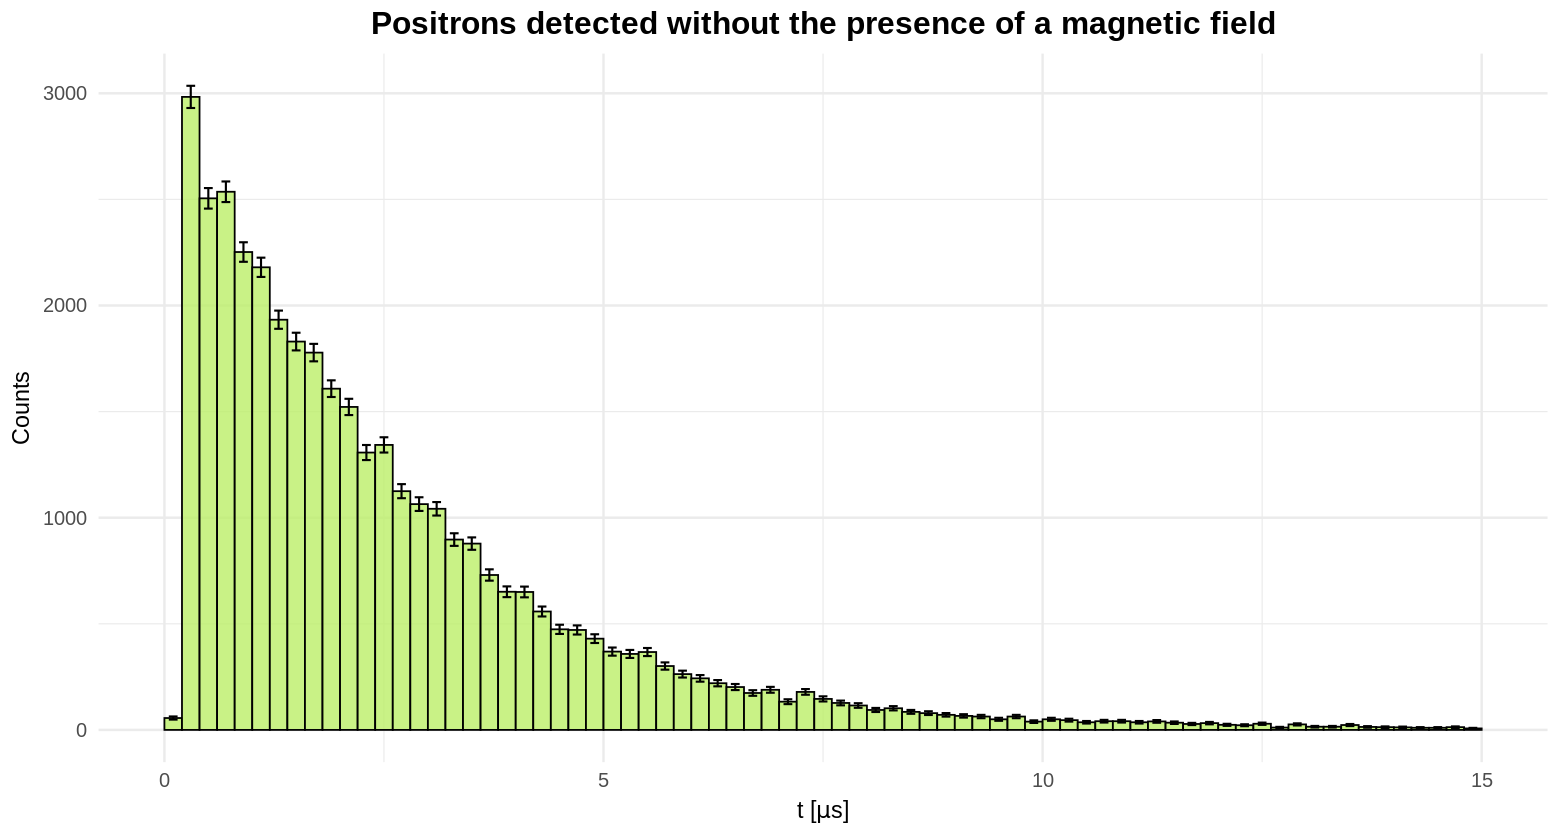

In [52]:
data.hist(df=df.lifetime, t0=0, by=dt)

We repeat the same procedure for the precession histogram, this time reducing the bin-size to $\Delta t = 0.1 \  \mu s$ to better visualize the oscilations induced by the precession of the muon's spins.

In [8]:
dt = 0.1
bins <- seq(0, max(df.precession$t)+dt, by=dt)

hist.precession <- hist(df.precession$t, breaks=bins, plot=FALSE)
data.precession <- data.frame(t=hist.precession$mids, I=hist.precession$counts)
data.precession$sigma <- sqrt(data.precession$I * (1 - data.precession$I/sum(data.precession$I))) # binomial errors

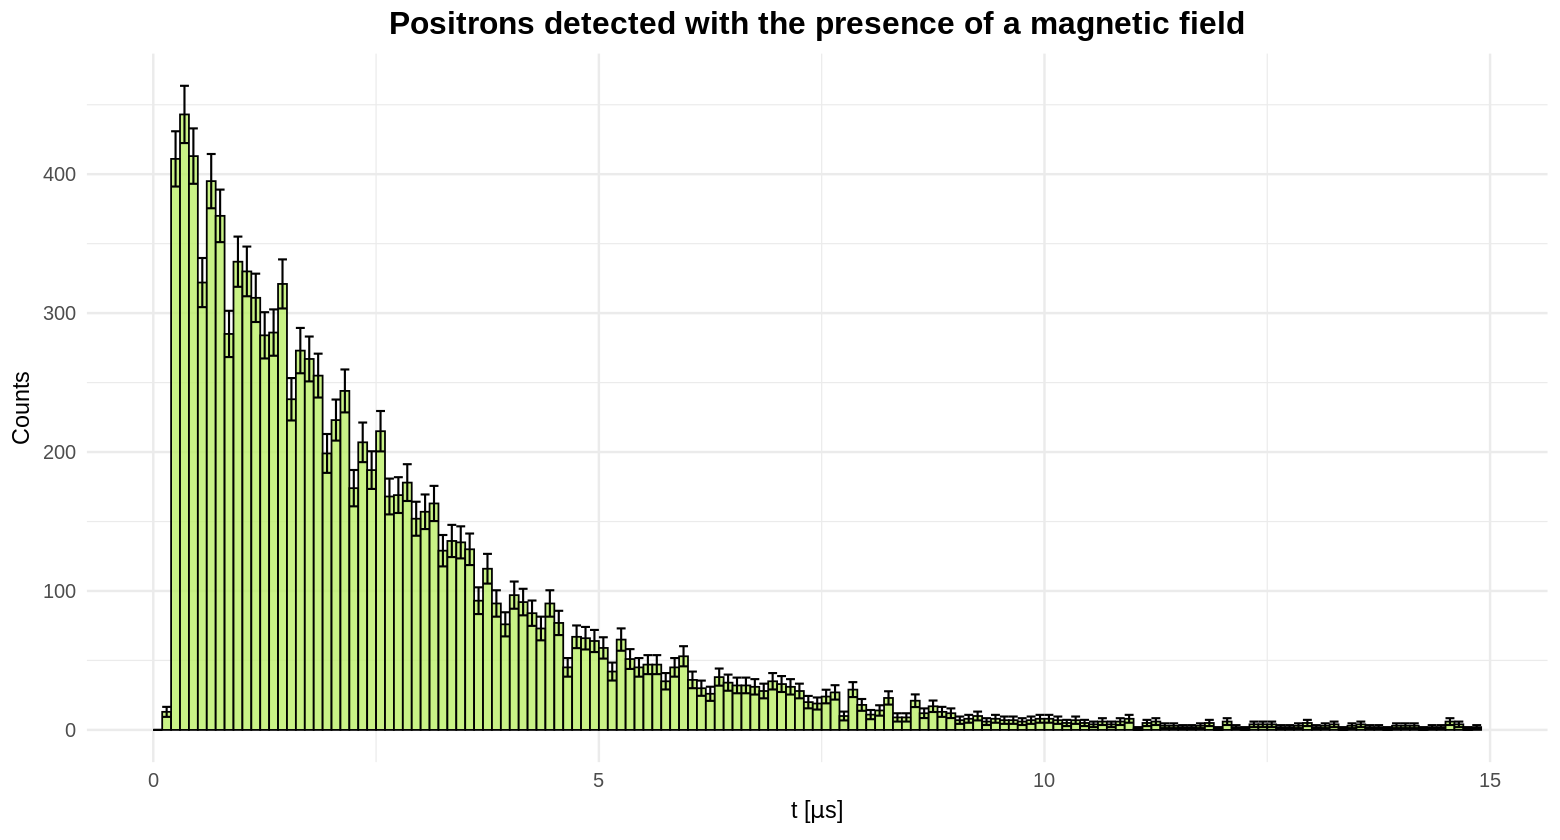

In [9]:
data.hist(df=df.precession, t0=0, by=dt, field=T)

### 3.2 Finding C

The constant $C$, representing the background in the measurement, was not treated as a free parameter in the fit; instead, it was determined from the data at large $t$ values. 

We do this by selecting all the bins after a specific (large) value of time, where we know the great majority of muons must have decayed. We obtain an estimate for $C$ as the mean value and the standard deviation of the counts in these bins.

Additionaly, we filter the data to a specific range of times: we select only times greater than $0.2 \ \mu s$ because the apparatus cannot accurately detect events occurring faster than this threshold. We also consider times no greater than four times the muon's lifetimes (approximately $2 \ \mu s$) to exclude the noisest part of our data.

In [10]:
# function to filter the data to a specific range of times and computes the noise
#      limits: is the time range onto which we want to restrict our data
#      cut: is the time after which we will compute the noise

noise.filter <- function(df, limits, cut){
    C <- as.integer(df %>% filter(t>cut) %>% summarize(noise = mean(I)) %>% pull(noise))
    sigma.C <- df %>% filter(t>cut) %>% summarize(err = sd(I)) %>% pull(err)
    df <- filter(df, t >= limits[1] & t <= limits[2])
    df$I <- df$I - C
    cat('Noise estimated as mean of tail counts:', C, '\nwith tail count variance:', sigma.C)
    return(df)
}

In [55]:
t.cut <- 13
t.lim <- c(0.2, 8.8)
data.lifetime.filt <- noise.filter(data.lifetime, t.lim, t.cut)

data.lifetime.filt$lnI <- log(data.lifetime.filt$I)
data.lifetime.filt$sigma <- data.lifetime.filt$sigma/data.lifetime.filt$I 

Noise estimated as mean of tail counts: 13 
with tail count variance: 4.263541

In [11]:
t.cut <- 10
t.lim <- c(0.4, 8.8)
data.precession.filt <- noise.filter(data.precession, t.lim, t.cut)

Noise estimated as mean of tail counts: 3 
with tail count variance: 1.937589

### 3.3 Estimate of lifetime $\tau$

We proceed to fit the `data.lifetime.filt` with a Markov Chain Monte Carlo algorithm (JAGS), based on a lineariziation of the underlying exponential model:

\begin{equation}
I(t)=I_{0}e^{-t/\tau} \longrightarrow ln[I(t)] = ln[I_{0}] - \frac{t}{\tau}
\end{equation}

where we omit the C parameter as it was previously subracted from the data. 

<br>

The two parameters of the model are:
- $ln[I_0]$: the logarithm of the counts related to the initial bin, representing the number of muon decays observed at the start of the measurements;
- $\tau$: the mean lifetime of the muon undergoing the decay process.

To fit the data through statistical inference we need to specify a prior probability distribution for each of these parameters. For $\tau$ we use a *gamma* distribution with mean and standard deviations given by the estimate of the Particle Data Group <a href="#trick">[1]</a>: 

\begin{equation}
\tau= 2.1969811 \pm 0.0000022 \ \mu s
\end{equation}

The $I_0$ true value is unknown and deeply depends on the experimental setting used to take the measurements. Since we do not have information regarding it, we obtain a rough estimate exploiting the model that we assume our data are following, using as $\tau$ the PDG estimate reported here above:

\begin{equation}
ln[I(t)] = ln[I_{0}] - \frac{t}{\tau} \longrightarrow ln[I_{0}] = ln[I(t)] + \frac{t}{\tau} 
\end{equation}

Using the value we have for the first bin of our analysis, $t=0.03$ and $lnI(t=0.03)=7.996317$, we obtain $I_0\approx8.01$. From this value we then consider a *normal* distribution centered on it. As standard deviation we use the binomial error a bin with such counts would have, obtaining $std=0.02$, so that:
\begin{equation}
\ln[I_0] \sim Norm(mean=8.01, std=0.02)
\end{equation}

Let's first define some functions:

In [13]:
# function to obtain the parameters of a beta distribution for a variable in the interval [a,b] with known mean and variance 
beta.params <- function(mean, variance, a, b){
    mu = (mean-a)/(b-a)
    var = variance/(b-a)^2
    alpha = mu*(mu*(1-mu)/var-1)
    beta = (1-mu)*(mu*(1-mu)/var-1)
    return (c(alpha, beta))
}

# function to obtain the parameters of a gamma distribution for a variable with known mean and variance
gamma.params <- function(mean, variance){
    alpha = mean^2/variance
    beta = mean/variance
    return (c(alpha, beta))
}

# function to plot the autocorrelation factor in function of the "lag", i.e. a number of samples after the one considered
autocorr_plot <- function(chain) {
    my.lags = seq(0,500,10)
    y1 <- coda::autocorr(chain, lags=my.lags)
    plot(my.lags , y1, ylim=c(0,1), pch=3, col='black', xlab='lag', ylab='ACF', cex=1.3)
    text(400,0.95, sprintf("effective size: %.2f",effectiveSize(chain)))
}

In [58]:
lifetime.params = gamma.params(mean=2.1969811, variance=0.0000022^2)
data.list <- list(t=data.lifetime.filt$t, lnI=data.lifetime.filt$lnI, sigma=data.lifetime.filt$sigma, lifetime=lifetime.params)

modelString <- "
model {
    lnI0 ~ dnorm(8.01,1/0.02);
    tau ~ dgamma(lifetime[1],lifetime[2]);
    
    # data likelihood
    for (i in 2:length(t)) {
     Z[i] <- lnI0 - t[i]/tau 
     lnI[i] ~ dnorm(Z[i], 1/sigma[i])
    }
}
"

jm <- jags.model(textConnection(modelString) , data.list)

update(jm , 5000) # burn-in
params.list = c("lnI0","tau")
chain <- coda.samples(jm , params.list, n.iter=100000, thin=3) # thinning

print(summary(chain))

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 42
   Unobserved stochastic nodes: 2
   Total graph size: 263

Initializing model


Iterations = 6003:105999
Thinning interval = 3 
Number of chains = 1 
Sample size per chain = 33333 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

      Mean        SD  Naive SE Time-series SE
lnI0 8.216 2.994e-02 1.640e-04      1.640e-04
tau  2.197 2.207e-06 1.209e-08      1.214e-08

2. Quantiles for each variable:

      2.5%   25%   50%   75% 97.5%
lnI0 8.157 8.196 8.216 8.236 8.274
tau  2.197 2.197 2.197 2.197 2.197



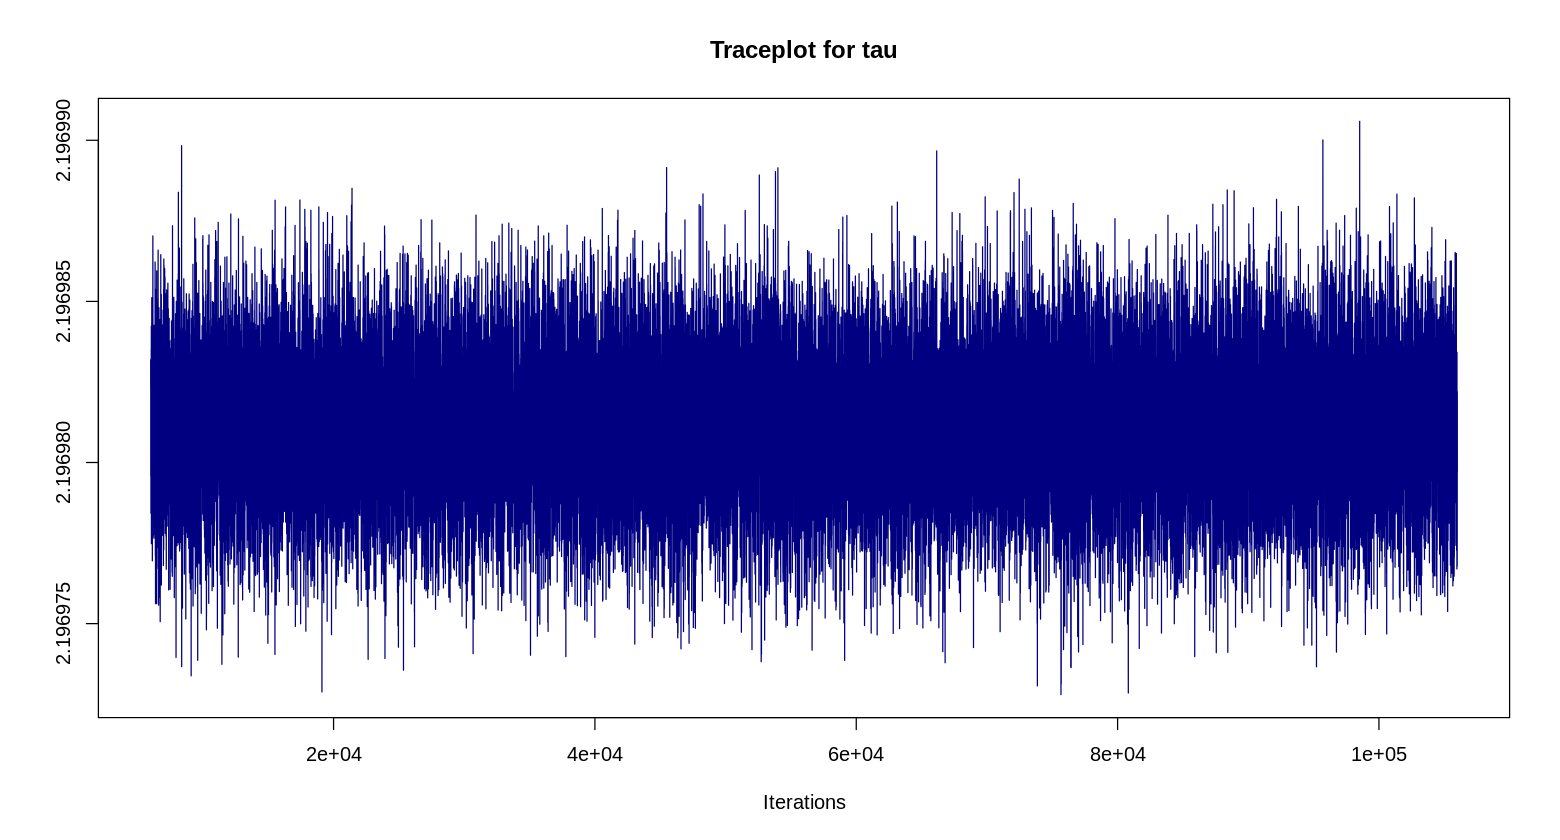

In [59]:
mean_lnI0 <- summary(chain)$statistics[,"Mean"]["lnI0"]

mean_tau <- summary(chain)$statistics[,"Mean"]["tau"]
sigma_tau <- summary(chain)$statistics[,"SD"]["tau"]
tau_quantiles <- summary(chain)$quantiles["tau", c("2.5%", "97.5%")]

traceplot(chain[, "tau"], col='navy', main='Traceplot for tau')

autocorr_plot(chain[[1]][, 2])
title(main=paste("Autocorrelation plot for tau"))

In [60]:
chain.df <- as.data.frame(as.mcmc(chain))

ggplot(chain.df, aes(x=tau)) +
  geom_histogram(aes(y=after_stat(density)), bins=100, fill='darkolivegreen2', color='black') +
  geom_vline(aes(xintercept=tau_quantiles["2.5%"], color="95% Credibility Interval"), linetype='solid') +
  geom_vline(aes(xintercept=tau_quantiles["97.5%"], color="95% Credibility Interval"), linetype='solid') +
  geom_vline(aes(xintercept=mean_tau-sigma_tau, color="Mean ± Sigma"), linetype='dashed') +
  geom_vline(aes(xintercept=mean_tau+sigma_tau, color="Mean ± Sigma"), linetype='dashed') +
  labs(x=expression(mu), y= 'Counts', title='Inference on muon lifetime') +
  theme_minimal(base_size=15) + 
  theme(
    plot.title = element_text(hjust = 0.5, size = 19, face = "bold"),
    axis.text = element_text(size = 12),
    axis.title = element_text(size = 14)
  ) +
  scale_color_manual(name = 'Legend',
                     values = c( "red", "blue"), 
                     breaks = c( "95% Credibility Interval", "Mean ± Sigma"),
                     labels = c( "95% Credibility Interval", "Mean ± Sigma")) +
 scale_x_continuous(breaks = seq(from = min(chain.df$tau), to = max(chain.df$tau), length.out = 5))

The histogram clearly shows that the expected value of $\tau=2.1969811$ lies well within the 95% credibility interval. This indicates that the data supports the previous theoretical predictions.

Below, we present the fitted data and the results obtained from running the MCMC algorithm:

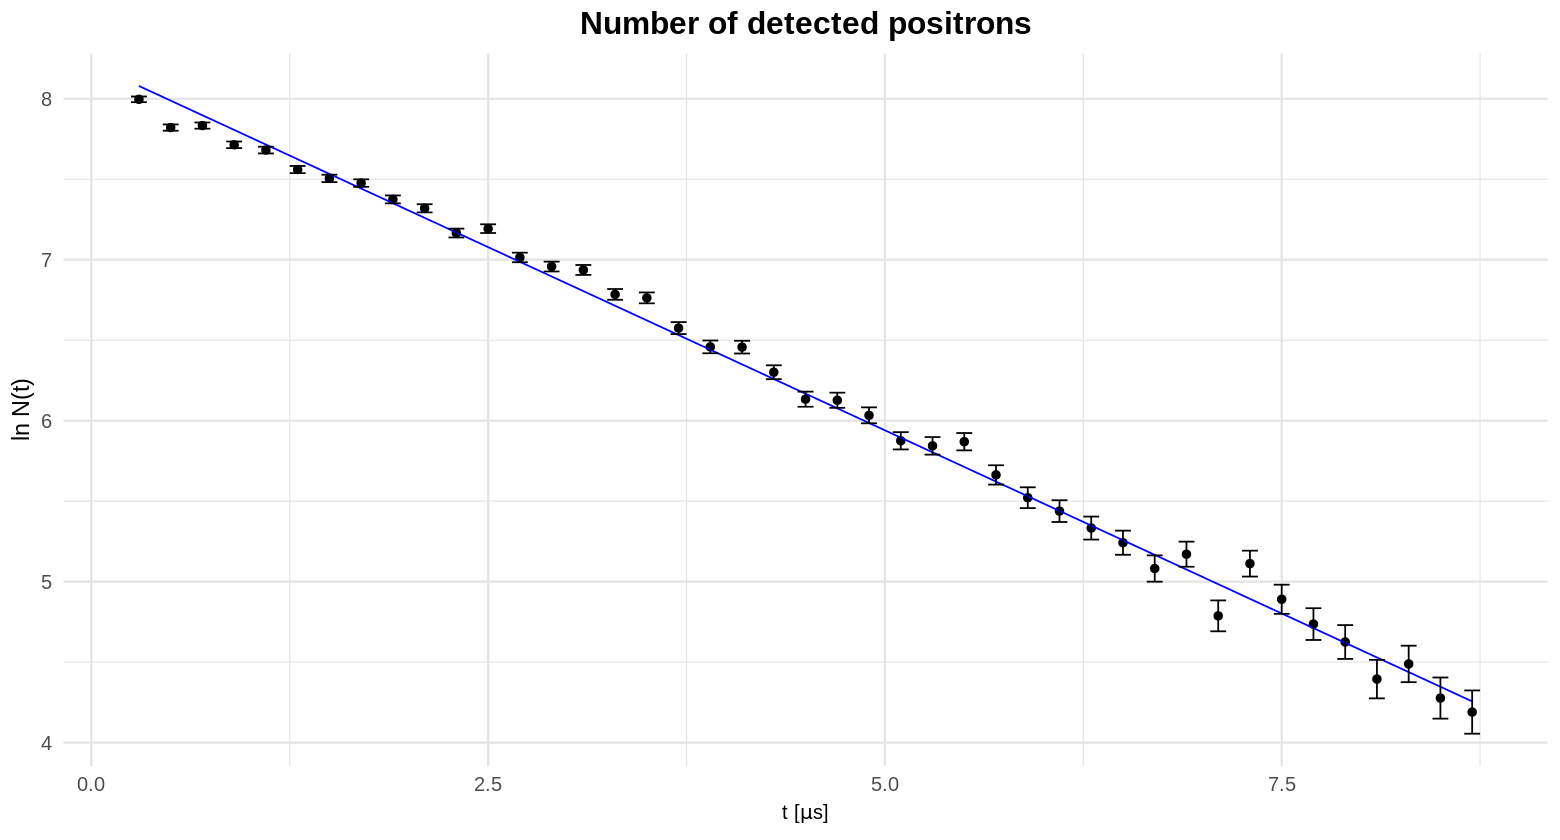

In [61]:
Z <- function(x) mean_lnI0 - (1/mean_tau) * x

data.lifetime.filt$Imin <- data.lifetime.filt$lnI - data.lifetime.filt$sigma
data.lifetime.filt$Imax <- data.lifetime.filt$lnI + data.lifetime.filt$sigma

ggplot(data.lifetime.filt, aes(x = t, y = lnI)) +
  geom_point(size=2) + 
  stat_function(fun = Z, color = "blue") +  
  geom_errorbar(aes(ymin = Imin, ymax = Imax), width = 0.1) + 
  labs(x = expression(t ~ "[" * mu * "s]"), y = "ln N(t)", title='Number of detected positrons') +
  theme_minimal(base_size = 15) +
  theme(
    plot.title = element_text(hjust = 0.5, size=19, face = "bold"),
    axis.title.x = element_text(size = 12),
    axis.title.y = element_text(size = 14),
    panel.grid.major = element_line(color = "gray90"),
    panel.grid.minor = element_line(color = "gray90")
  )

### 3.4 Estimate of the precession frequency $\omega$

We now proceed to fit the `data.precession.filt` with the same tecnique. However, this time we will use the original model instead of its linearized version. This is because the model is not a pure exponential decay but it is modulated by a sinusoidal oscillation:

\begin{equation}
I(t)=I_{0}e^{-t/\tau} \ [1 + \alpha \ cos \ (\omega t + \delta)]
\end{equation}

<br>

The parameters of the model are are:

- $\tau$, the muon lifetime. We once again use the PDG estimate, considering a *gamma* prior with:
\begin{equation}
\tau= 2.1969811 \pm 0.0000022 \ \mu s 
\end{equation}

- $\omega$, the Larmor's frequency of the muon in the magnetic field $B$. We can use the following theoretical formula to obtain an estimate of its true value: 
\begin{equation}
\omega = g_{\mu} \frac{eB}{2m_{\mu}}
\end{equation}
Here, we assume $g_{\mu}=2 \ rad \ s^{-1} T^{-1}$, $B=5.6 \ \pm 0.02 \ mT$, and the known constants for the muon charge and mass <a href="#trick">[1]</a>. Using the error propagation formula we can compute the error associated to it. Finally, we consider a *normal* prior with:
\begin{equation}
\omega= 4.77 \pm 0.06 \ Hz\ 
\end{equation}

- $\delta$, the angle of initial muon polarization. This angle is related to the overall angular distribution of muons at Earth's surface. According to experiments, this distribution is approximately $I_{0} cos^2 \theta$, where $\theta$ is the zenith angle and $I_{0} = 70 m^{−2}s^{-1}sr^{−1}$. <a href="#delta">[2]</a> Theoretically, the peak should be at $\theta_{0} = 0$ and this is the value we choose as mean of the prior distribution. The variance of such distribution is then obtained as $var = \dfrac{\int^{\frac{\pi}{2}}_{-\frac{\pi}{2}} (\theta - \theta_{0})^2 I_{0} cos^2 {\theta} \ d\theta}{Z} = 0.32$, where $Z$ is a a normalization factor. As seen as $\delta \ \epsilon  [-\frac{\pi}{2}, \frac{\pi}{2}]$, we choose a *beta* prior with:
\begin{equation}
\delta= 0 \pm  0.57 
\end{equation}

- $\alpha$, the experimental asymmetry. We know from theory that the asymmetry terms is defined in the interval $[-\frac{1}{3}, 1]$, with a mean value of $\frac{1}{3}$.  In practice, $\alpha$ accounts for various factors in a real experimental setup and is generally smaller than the theoretical value. We choose a *beta* prior, with a mean value of:
\begin{equation}
\alpha=0.05 \pm 0.01
\end{equation}

- $I_0$, the counts as $t=0$. As previously mentioned, its true value is unknown and we obtain a rough estimate exploiting the model that we assume our data are following, using as $\tau$, $\omega$, $\delta$ and $\alpha$ the estimates presented above:
\begin{equation}
I_{0} = I(t) \dfrac{e^{\frac{t}{\tau}}}{1 + \alpha \ cos(\omega t + \delta) }
\end{equation}
Using the value we have for the first bin of our analysis, $t=0.35$ and $I(t=0.35)=440$, we obtain $I_0\approx518$. From this value we then consider a *normal* distribution centered on it. As standard deviation we use the binomial error a bin with such counts would have, obtaining $std=23$, so that:
\begin{equation}
I_0= 518 \pm  23 
\end{equation}

In [14]:
lifetime.params = gamma.params(mean=2.1969811, variance=0.0000022^2)
phase.params = beta.params(mean=0, variance=0.32, -3.14/2, 3.14/2)
asim.params = beta.params(mean=0.05, variance=0.01^2, -1/3, 1)

data.list <- list(t=data.precession.filt$t, I=data.precession.filt$I, sigma=data.precession.filt$sigma, 
                  phase=phase.params, asim=asim.params, lifetime=lifetime.params)

modelString <- "
model {
    I0 ~ dnorm(518, 1/23);
    omega ~ dnorm(4.77,1/0.06);
    x ~ dbeta(asim[1],asim[2]);
    y ~ dbeta(phase[1], phase[2]);
    alpha <- (4/3*x)-1/3;
    delta <- (3.14*x)-3.14/2;
    tau ~ dgamma(lifetime[1],lifetime[2]);

    # data likelihood
    for (i in 1:length(t)) {
     Z[i] <- I0*exp(-t[i]/tau) * (1+alpha*cos(omega*t[i]+delta))
     I[i] ~ dnorm(Z[i], 1/sigma[i])
    }
}
"

jm <- jags.model(textConnection(modelString) , data.list)

update(jm , 5000)
params.list= c('I0', 'alpha', 'omega', 'delta', 'tau')
chain <- coda.samples(jm ,params.list, n.iter=100000, thin=1)

print(summary(chain))

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 84
   Unobserved stochastic nodes: 5
   Total graph size: 1112

Initializing model


Iterations = 6001:106000
Thinning interval = 1 
Number of chains = 1 
Sample size per chain = 1e+05 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

           Mean        SD  Naive SE Time-series SE
I0    529.65383 1.402e+00 4.432e-03      4.604e-03
alpha   0.05475 3.920e-03 1.240e-05      1.623e-05
delta  -0.65607 9.232e-03 2.919e-05      3.821e-05
omega   4.52485 4.063e-02 1.285e-04      1.714e-04
tau     2.19698 2.204e-06 6.971e-09      8.972e-09

2. Quantiles for each variable:

           2.5%      25%       50%       75%     97.5%
I0    526.89872 528.7088 529.64959 530.60047 532.40434
alpha   0.04709   0.0521   0.05476   0.05739   0.06244
delta  -0.67410  -0.6623  -0.65605  -0.64984  -0.63796
omega   4.44602   4.4974   4.52

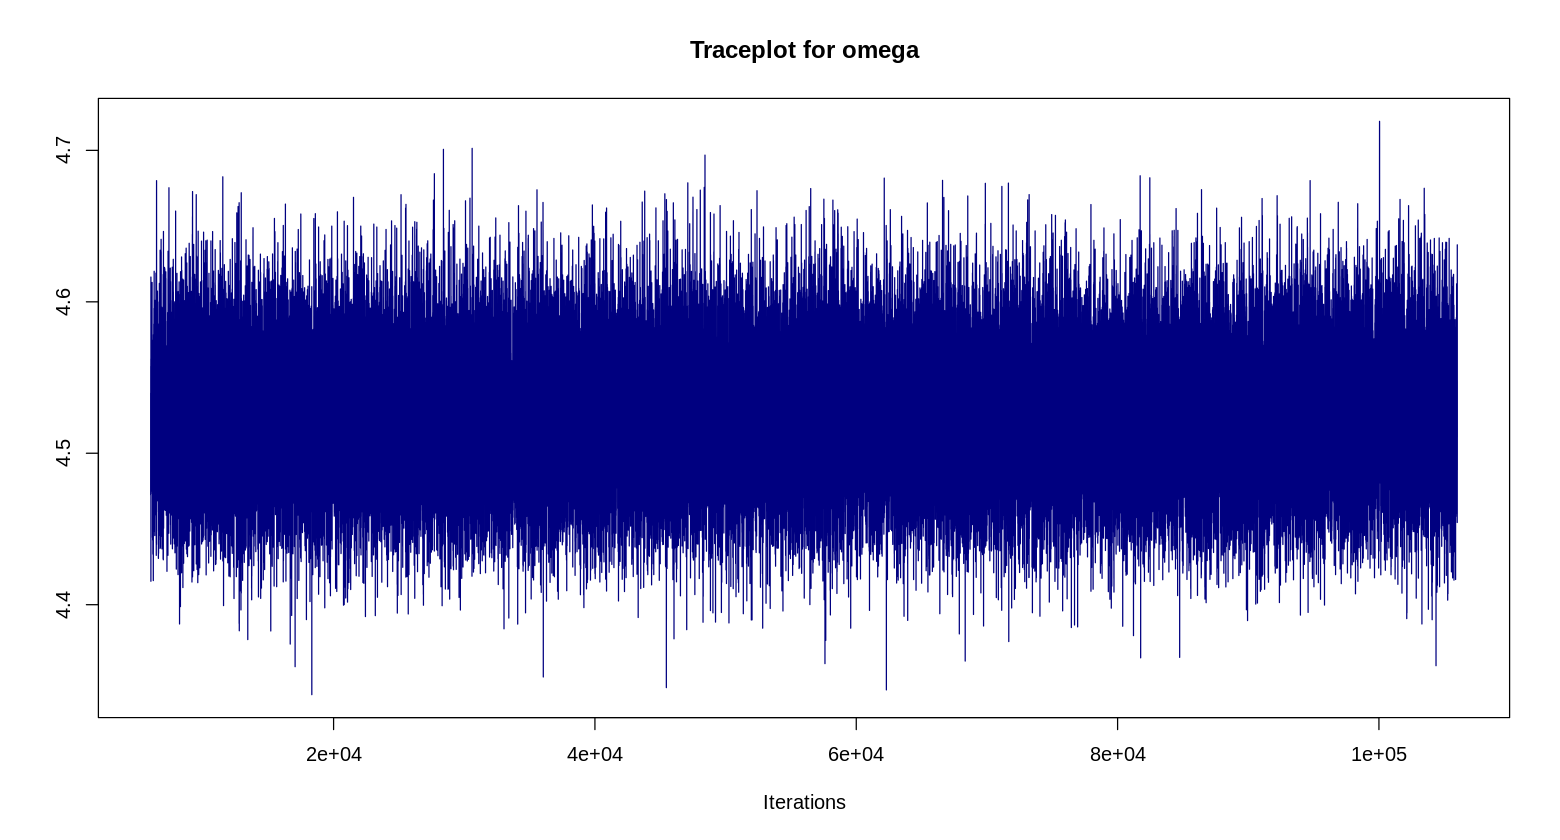

In [15]:
mean_I0 <- summary(chain)$statistics[,"Mean"]["I0"]

mean_tau <- summary(chain)$statistics[,"Mean"]["tau"]
sigma_tau <- summary(chain)$statistics[,"SD"]["tau"]
tau_quantiles <- summary(chain)$quantiles["tau", c("2.5%", "97.5%")]

mean_alpha <- summary(chain)$statistics[,"Mean"]["alpha"]
sigma_alpha <- summary(chain)$statistics[,"SD"]["alpha"]
alpha_quantiles <- summary(chain)$quantiles["alpha", c("2.5%", "97.5%")]

mean_delta <- summary(chain)$statistics[,"Mean"]["delta"]
sigma_delta<- summary(chain)$statistics[,"SD"]["delta"]
delta_quantiles <- summary(chain)$quantiles["delta", c("2.5%", "97.5%")]

mean_omega <- summary(chain)$statistics[,"Mean"]["omega"]
sigma_omega <- summary(chain)$statistics[,"SD"]["omega"]
omega_quantiles <- summary(chain)$quantiles["omega", c("2.5%", "97.5%")]

traceplot(chain[, "tau"], col='navy', main='Traceplot for tau')
traceplot(chain[, "alpha"], col='navy', main='Traceplot for alpha')
traceplot(chain[, "delta"], col='navy', main='Traceplot for delta')
traceplot(chain[, "omega"], col='navy', main='Traceplot for omega')

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”
Warning message:
“The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead.”


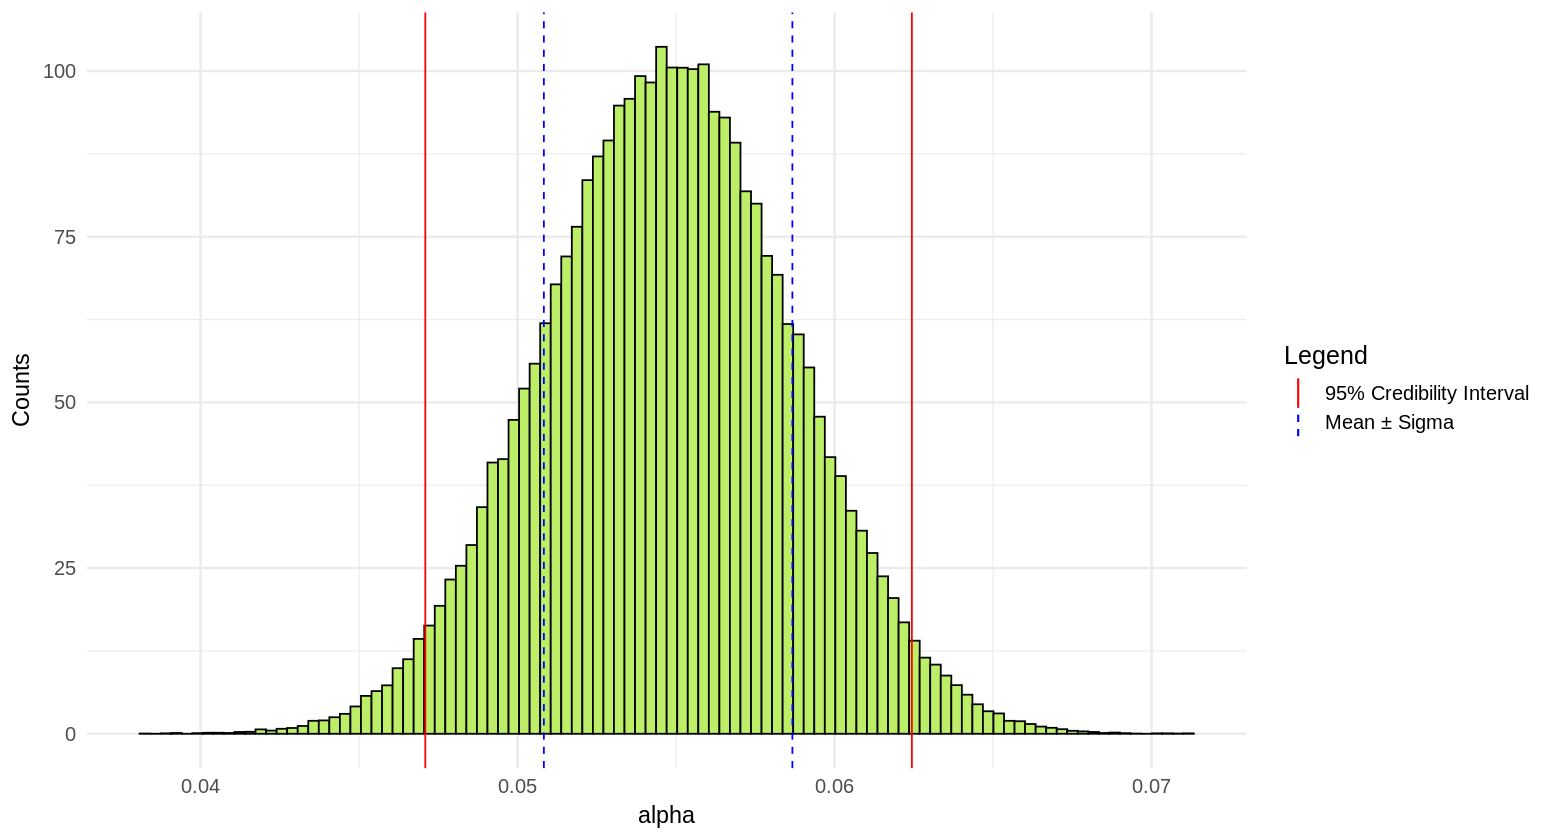

In [16]:
chain.df <- as.data.frame(as.mcmc(chain))
params <- list(alpha=list(alpha_quantiles, mean_alpha, sigma_alpha), 
               delta=list(delta_quantiles, mean_delta, sigma_delta), 
               omega=list(omega_quantiles, mean_omega, sigma_omega))
plots = list()

for (i in 1:3){
    param <- names(params)[i]
    quantiles <- params[[i]][[1]]
    mean=params[[i]][[2]]
    sigma=params[[i]][[3]]
    p <-ggplot(chain.df, aes_string(x=param)) + 
        geom_histogram(aes(y=..density..), bins=100, fill='darkolivegreen2', color='black') +
        geom_vline(aes(xintercept=quantiles["2.5%"], color="95% Credibility Interval"), linetype='solid') +
        geom_vline(aes(xintercept=quantiles["97.5%"], color="95% Credibility Interval"), linetype='solid') +
        geom_vline(aes(xintercept=mean-sigma, color="Mean ± Sigma"), linetype='dashed') +
        geom_vline(aes(xintercept=mean+sigma, color="Mean ± Sigma"), linetype='dashed') +
        theme_minimal(base_size=15) + 
        labs(y= 'Counts') +
        theme(
        plot.title = element_text(hjust = 0.5, size = 19, face = "bold"),
        axis.text = element_text(size = 12),
        axis.title = element_text(size = 14))+
        scale_color_manual(name = 'Legend',
                            values = c( "red", "blue"), 
                             breaks = c( "95% Credibility Interval", "Mean ± Sigma"),
                             labels = c( "95% Credibility Interval", "Mean ± Sigma"))
    print(p)
    }

The histograms show that the expected value for $\alpha$ lies in the 95% credibility interval. However, this is not the case for $\omega$ suggesting that a binned analysis may not be optimal given the limited number of data points available for fitting. Consequently, we will explore an unbinned analysis to evaluate its performance on the dataset.

Below, we present the fitted data and the results obtained from running the MCMC algorithm:

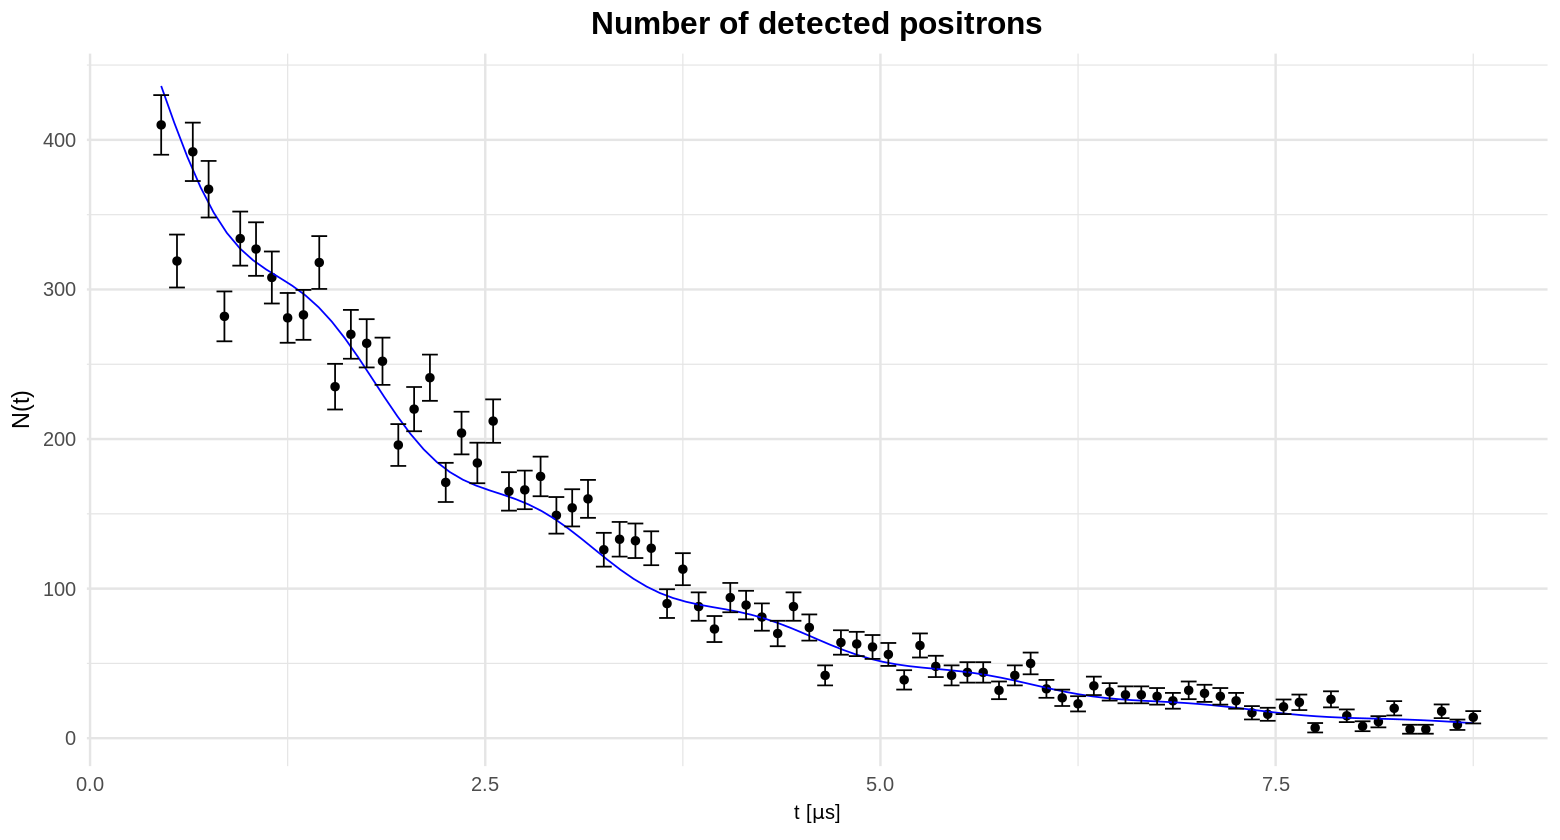

In [17]:
Z <- function(x) {
  mean_I0 * exp(-x / mean_tau) * (1 + mean_alpha * cos(mean_omega * x + mean_delta))
}

data.precession.filt$Imin <- data.precession.filt$I - data.precession.filt$sigma
data.precession.filt$Imax <- data.precession.filt$I + data.precession.filt$sigma

ggplot(data.precession.filt, aes(x = t, y = I)) +
  geom_point(size=2) +  
  stat_function(fun = Z, color = "blue") +  
  geom_errorbar(aes(ymin = Imin, ymax = Imax), width = 0.1) +
  labs(x = expression(t ~ "[" * mu * "s]"), y = "N(t)", title='Number of detected positrons') +
  theme_minimal(base_size = 15) +
  theme(
    plot.title = element_text(hjust = 0.5, size=19, face = "bold"),
    axis.title.x = element_text(size = 12),
    axis.title.y = element_text(size = 14),
    panel.grid.major = element_line(color = "gray90"),
    panel.grid.minor = element_line(color = "gray90")
  )

### 2.5 Estimate of gyromagnetic ratio

The gyromagnetic ratio is predicted by the Dirac equation to be exactly 2 for leptons, but the experimentally determined $g_{\mu}$- value differs slightly from this theoretical expectation, an inconsistency called _the magnetic moment anomaly_. The errors in our current calculations are too large to detect such a small difference. Therefore, in this project, we will focus on verifying whether the obtained value of the gyromagnetic ratio is consistent with the theoretical one.


In [19]:
mass_mu <- 105.66e+06 #eV
c <- 2.998e+08 #m/s

field <- 5.6e-03 #T
sigma_field <- 0.02*field/sqrt(12) #T

omega <- mean_omega * 1e+06 #Hz

g_mu <- 2 * mass_mu * omega/(field * c^2)

# using error propagation formula 
sigma_g <- g_mu * sqrt((sigma_field/field)^2 + (sigma_omega/omega)^2)

cat(paste('g muon:', g_mu, '+-', sigma_g))

g muon: 1.89973574679475 +- 0.0109681294480243

<hr style="border:2px solid gray">

## 4. Unbinned analysis

### 4.1 Data Preparation

As highlighted from the binned analysis the known laws of decay only start being applicable to the measurements after around $t_0 = 0.6 \ \mu\text{s}$, as a result of the experimental setup. We decide to keep the measurements higher than $t_0$, which means the likelihood becomes its truncated variant. As we will show with equations this is not an issue when defining the MCMC models since truncating a pdf only affects the normalization constant and its support.

$$
f(t|t>t_0;\boldsymbol{\theta}) = \dfrac{f(t|\boldsymbol{\theta})}{f(t>t_0|\boldsymbol{\theta})} = \dfrac{f(t|\boldsymbol{\theta})}{1 - P(t_0|\boldsymbol{\theta})}\:,\:t\in(t_0, +\infty)
$$

Where $f$ is the likelihood and $P$ is its relative cumulative pdf.

In [58]:
t0 <- 0.6
lifetime.new <- df.lifetime %>% filter(t > t0) %>% 
mutate(t.prime = t - t0) %>% slice_sample(prop=1)
precession.new <- df.precession %>% filter(t > t0) %>%
mutate(t.prime = t - t0) %>% slice_sample(prop=1)

Let's first define some functions:

In [59]:
posterior.plot <- function(chain, param){
    chain.df <- as.data.frame(as.mcmc(chain))
    quantiles <- summary(chain)$quantiles[param, c("2.5%", "97.5%")]
    title <- paste(param, ' posterior')
    mean_val <- mean(chain.df[[param]])
    dens <- density(chain.df[[param]])
    dens_df <- data.frame(x = dens$x, y = dens$y)
    p <- ggplot(dens_df, aes(x = x, y = y)) + 
            geom_line(color = 'black', size=1) +
            geom_area(data = subset(dens_df, x >= quantiles["2.5%"] & x <= quantiles["97.5%"]),
                      fill = 'red', alpha = 0.6) +
            geom_vline(aes(xintercept = mean_val), linetype = "dashed", size = 1, color='blue') +
            theme_minimal(base_size = 15) + 
            theme(
                plot.title = element_text(hjust = 0.5, size = 19, face = "bold"),
                axis.text = element_text(size = 12),
                axis.title = element_text(size = 14)
            ) +
            labs(y = "Density", x = param, title = title)
    return(p)
}

chain.plot <- function(chain, pars = NA){
    if (all(is.na(pars))) {
      params <- varnames(chain[[1]])
    } else {
      params <- pars
    }
    N.samples <- nrow(chain[[1]])
    plots <- list()
    for (i in 1:length(params)){
        param <- params[i]
        trace <- traceplot(chain[, param], col = 'navy', main = paste('Traceplot for ', param))
        lags <- seq(0, N.samples, by = 10)
        acf <- autocorr(as.mcmc(chain[, param]), lags=lags, relative=F)
        acorr <- plot(lags, acf, ylim=c(0,1), pch=12, col='navy',
                      xlab='Lag', ylab='ACF', cex=1.3,
                      main = paste('Autocorrelation for ', param)) 
        plots[[2*(i-1)+1]] <- trace
        plots[[2*i]] <- acorr
    }
    n_plots <- length(plots)
    return(do.call(grid.arrange, c(plots, nrow = 2*length(params), ncol = 1)))
}

In [60]:
data.hist(lifetime.new, t0, 0.15, filt=T)

In [61]:
data.hist(precession.new, t0, 0.15, field=T, filt=T)

### 4.2 Zero trick JAGS <a href="#trick">[3]</a>

Jags doesn't allow custom likelihood distributions, so we have to adopt a trick.
If $l_i(\boldsymbol{\theta}) = \log f(t_i|\boldsymbol{\theta})$ is the loglikelihood of a single observation then:


$$
f(\{t_i\}|\boldsymbol{\theta}) = \prod^n_{i=1} e^{l_i(\boldsymbol{\theta})} = \prod^n_{i=1}\dfrac{e^{-(-l_i(\boldsymbol{\theta}))}(-l_i(\boldsymbol{\theta}))^0}{0!} =  \prod^n_{i=1} f_{\text{pois}}(0|-l_i(\boldsymbol{\theta}))
$$

Which means the problem can be refactored as the poisson likelihood of drawing zero $n$ times from a dummy Poisson variable with given rate $-l_i(\boldsymbol{\theta})$.

The Poisson rate has to be positive but we can add a constant $M > \max_i(l_i(\boldsymbol{\theta}))$ and recover a multiplying factor which will just affect the normalization of the posterior.

#### 4.2.1 Estimate of lifetime $\tau$

A detection event at time $t$ is the union of three events with different time distributions: the first is the exponential law for the positive muon decay, the second is the exponential law of the negative muon stopped by the copper nuclei and the third is the background. Since the expected time for negative muons to be stopped <a href="#capture">[4]</a> is $\tau_{-} \approx 0.16 \mu\text{s}$ and the cutoff time is rougly three times higher we choose to ignore it. The background instead is still treated as a Poisson event but with a rate $1/b<<1/{\tau_{+}}$ so it manifests as a constant count addition in the binned analysis. The background arrival rate is not fitted but just fixed to a high value.

As a result in the first case the likelihood for a single measurement is 
$$
f(t|\tau, b, C) = \dfrac{1-C}{\tau}e^{-t/\tau} + \dfrac{C}{b}e^{-t/b}
$$

In [62]:
lifetime.string <- '
model {
    
    #constants
    M <- 1000
    b <- background
    
    #Likelihood
    for (i in 1:length(t)){
        dummy[i] ~ dpois(-l[i] + M)
        f[i] <- (1 - C)/tau * exp(-t[i]/tau) + C/b * exp(-t[i]/b)
        l[i] <- log(f[i])
    }

    #Priors
    tau ~ dgamma(lifetime[1],lifetime[2]); #PDG reference
    C ~ dbeta(1, 1);
}
'

In [63]:
lifetime.params = gamma.params(mean=2.1969811, variance=0.0000022^2)
data.lifetime <- list(t = lifetime.new$t, dummy = numeric(length(lifetime.new$t)), lifetime=lifetime.params,
                     background = 1000)

lifetime.model <- jags.model(file = textConnection(lifetime.string),
                             data = data.lifetime, n.chains = 1)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 31985
   Unobserved stochastic nodes: 2
   Total graph size: 73814

Initializing model



In [64]:
update(lifetime.model, 1000)
lifetime.chain <- coda.samples(lifetime.model , c('C', 'tau'), n.iter=8000, thin = 2)
print(summary(lifetime.chain))


Iterations = 2002:10000
Thinning interval = 2 
Number of chains = 1 
Sample size per chain = 4000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

         Mean        SD  Naive SE Time-series SE
C   0.0000318 3.282e-05 5.189e-07      9.489e-07
tau 2.1969812 2.154e-06 3.405e-08      3.417e-08

2. Quantiles for each variable:

         2.5%       25%       50%       75%     97.5%
C   7.852e-07 8.817e-06 2.181e-05 4.397e-05 0.0001193
tau 2.197e+00 2.197e+00 2.197e+00 2.197e+00 2.1969853



In [65]:
posterior.plot(lifetime.chain, 'tau')

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


#### 4.2.2 Estimate of precession frequency $\omega$

With the magnetic field turned on we expect a likelihood (unnormalized):
$$
f(t|\tau, \alpha, \omega, \delta, b, C) = e^{-t/\tau}(1+\alpha \cos(\omega t + \delta)) + Ce^{-t/b}
$$

We estimate the spin gyromagnetic factor $g_{\mu}$ as

$$
g_{\mu} = \dfrac{2m_{\mu}\omega}{eB}
$$

In [66]:
oscillation.string <- '
model {
    
    #constants
    M <- 1000
    b <- background
    m <- 105.6e+06
    c <- 2.997e+08
    B <- 5.6e-03

    #likelihood
    for (i in 1:length(t)){
        dummy[i] ~ dpois(-l[i] + M)
        f[i] <- exp(-t[i]/tau) * (1 + alpha * cos(omega * t[i] + delta)) + C * exp(-t[i]/b)
        l[i] <- log(f[i])
    }
    
    #Priors
    omega ~ dnorm(4.76,1/0.06);
    x ~ dbeta(asim[1],asim[2]);
    y ~ dbeta(phase[1], phase[2]);
    alpha <- (4/3*x)-1/3;
    delta <- (3.14*x)-3.14/2;
    tau ~ dgamma(lifetime[1],lifetime[2]);
    C ~ dunif(0, 1);

    #Error propagation
    field ~ dnorm(B, sqrt(12)/(0.02*B)) #2% max error
    g <- 1e+06 * 2 * m * omega/(B * c^2)
}
'

In [67]:
lifetime.params = gamma.params(mean=2.1969811, variance=0.0000022^2)
phase.params = beta.params(mean=0, variance=0.32, -3.14/2, 3.14/2)
asim.params = beta.params(mean=0.05, variance=0.01^2, -1/3, 1)

data.precession <- list(t = precession.new$t, dummy = numeric(length(lifetime.new$t)),
                     background = 1000, asim = asim.params, phase = phase.params, lifetime=lifetime.params)

In [68]:
oscillation.model <- jags.model(file = textConnection(oscillation.string),
                             data = data.precession, n.chains = 1)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 9488
   Unobserved stochastic nodes: 6
   Total graph size: 53276

Initializing model



In [69]:
update(oscillation.model, 1000)
oscillation.chain <- coda.samples(oscillation.model, thin = 2,
                                  c('C', 'tau', 'alpha', 'delta', 'omega', 'g'), n.iter=4000)
print(summary(oscillation.chain))


Iterations = 2002:6000
Thinning interval = 2 
Number of chains = 1 
Sample size per chain = 2000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

          Mean        SD  Naive SE Time-series SE
C      0.99986 1.329e-04 2.973e-06      4.504e-06
alpha  0.02443 1.030e-02 2.302e-04      2.648e-04
delta -0.72746 2.425e-02 5.422e-04      6.236e-04
g      2.07749 1.170e-01 2.616e-03      2.918e-03
omega  4.94774 2.786e-01 6.230e-03      6.950e-03
tau    2.19698 2.237e-06 5.002e-08      5.002e-08

2. Quantiles for each variable:

           2.5%      25%      50%      75%    97.5%
C      0.999510  0.99981  0.99990  0.99996  1.00000
alpha  0.004468  0.01738  0.02445  0.03142  0.04458
delta -0.774478 -0.74406 -0.72742 -0.71101 -0.68001
g      1.855259  1.99948  2.07382  2.15483  2.31056
omega  4.418472  4.76194  4.93899  5.13193  5.50282
tau    2.196977  2.19698  2.19698  2.19698  2.19699



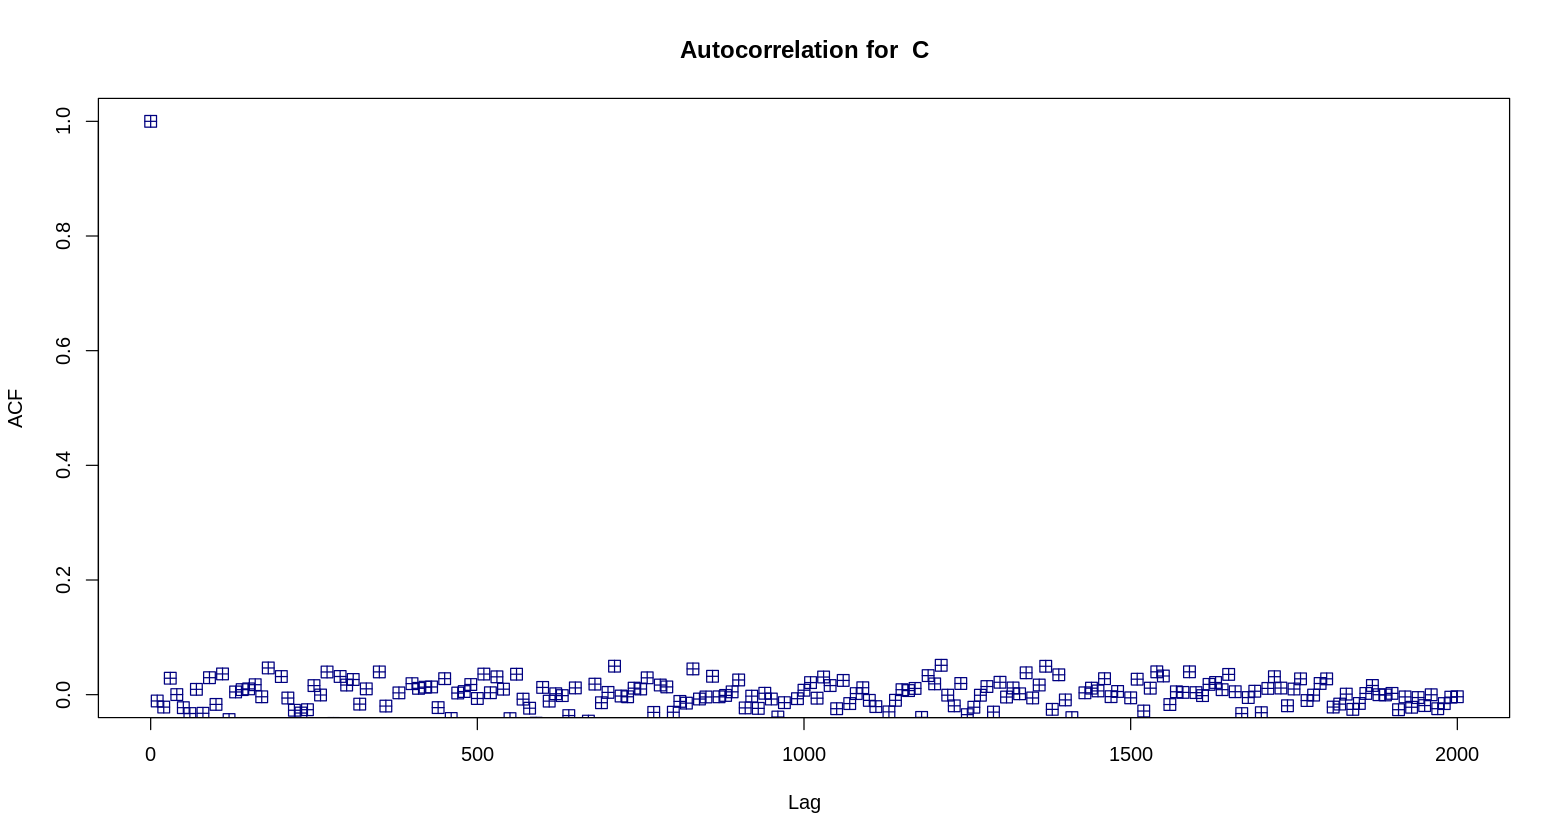

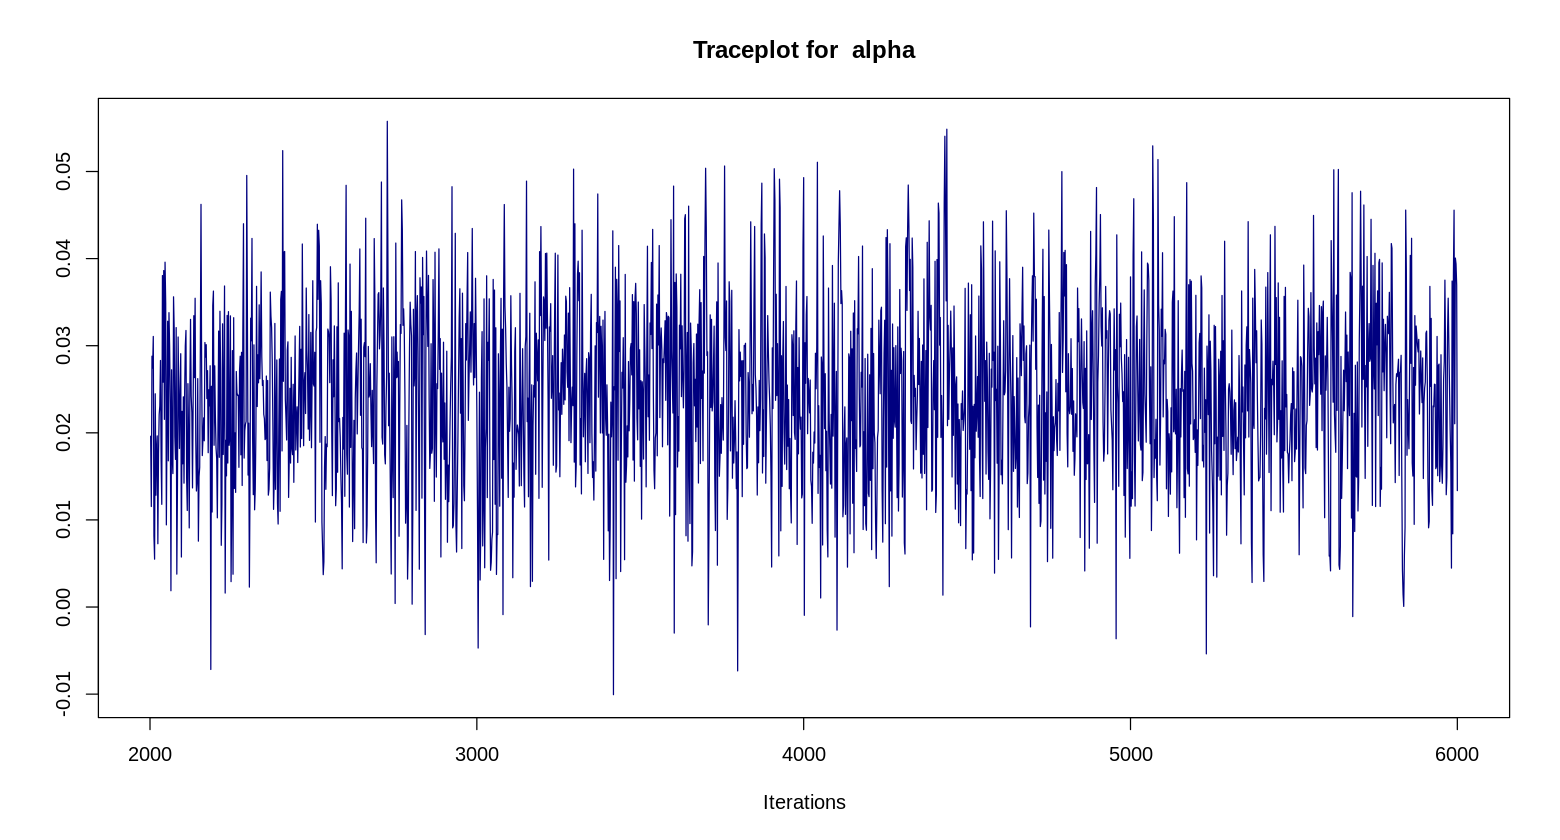

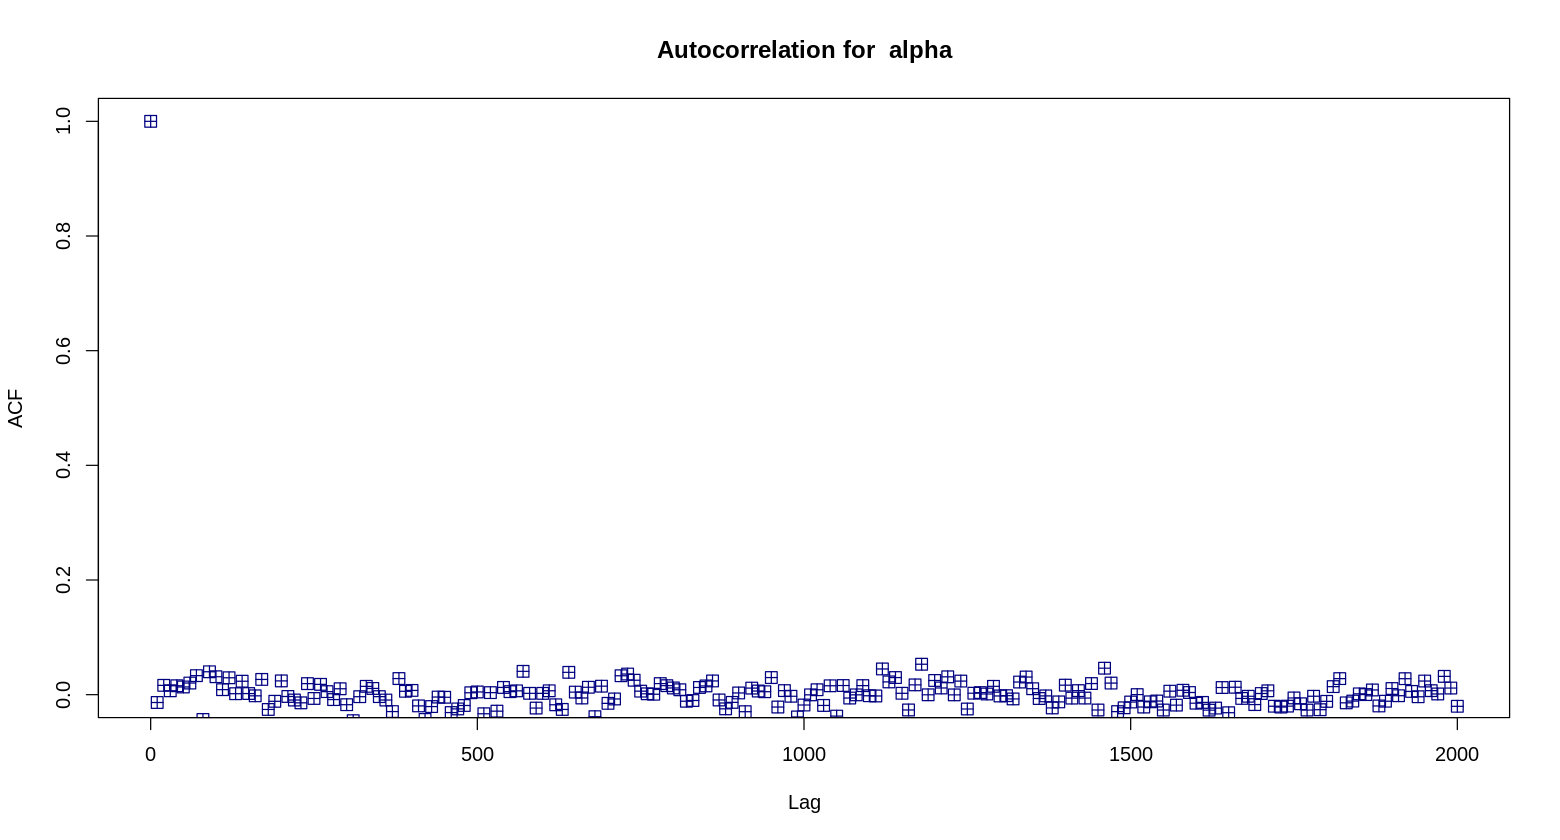

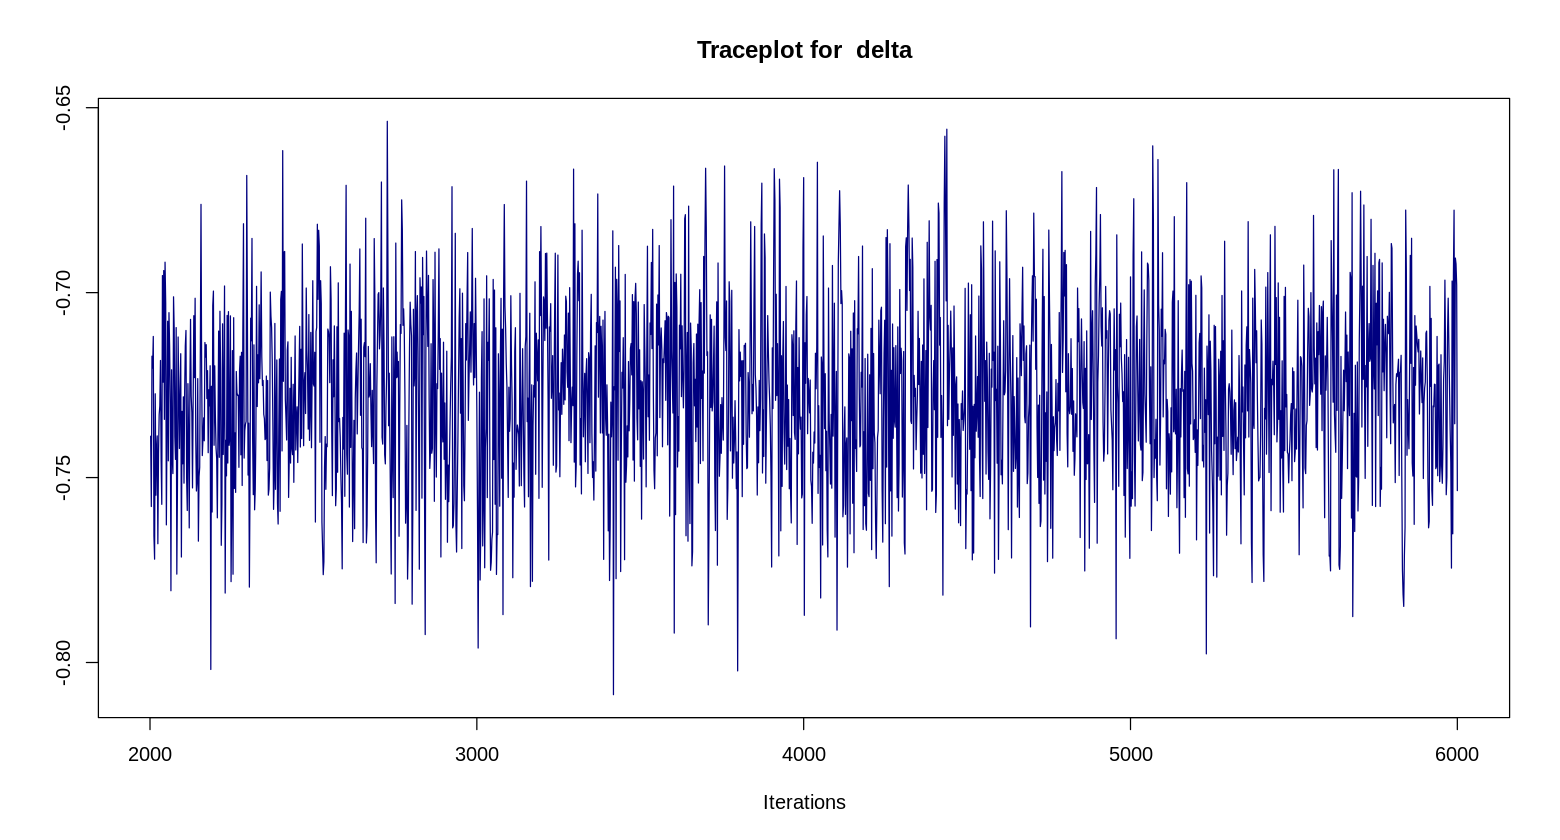

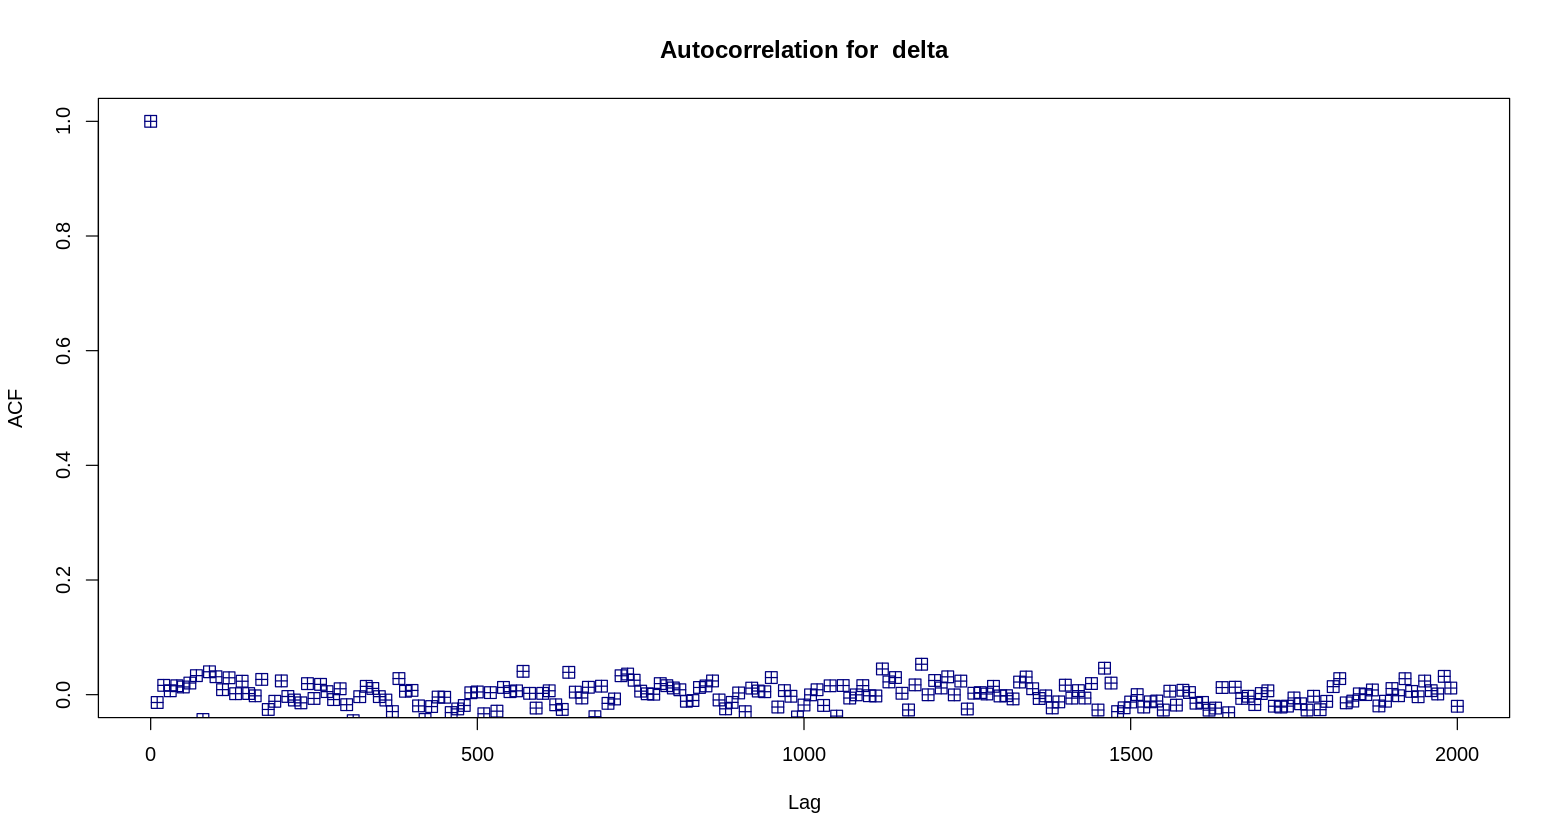

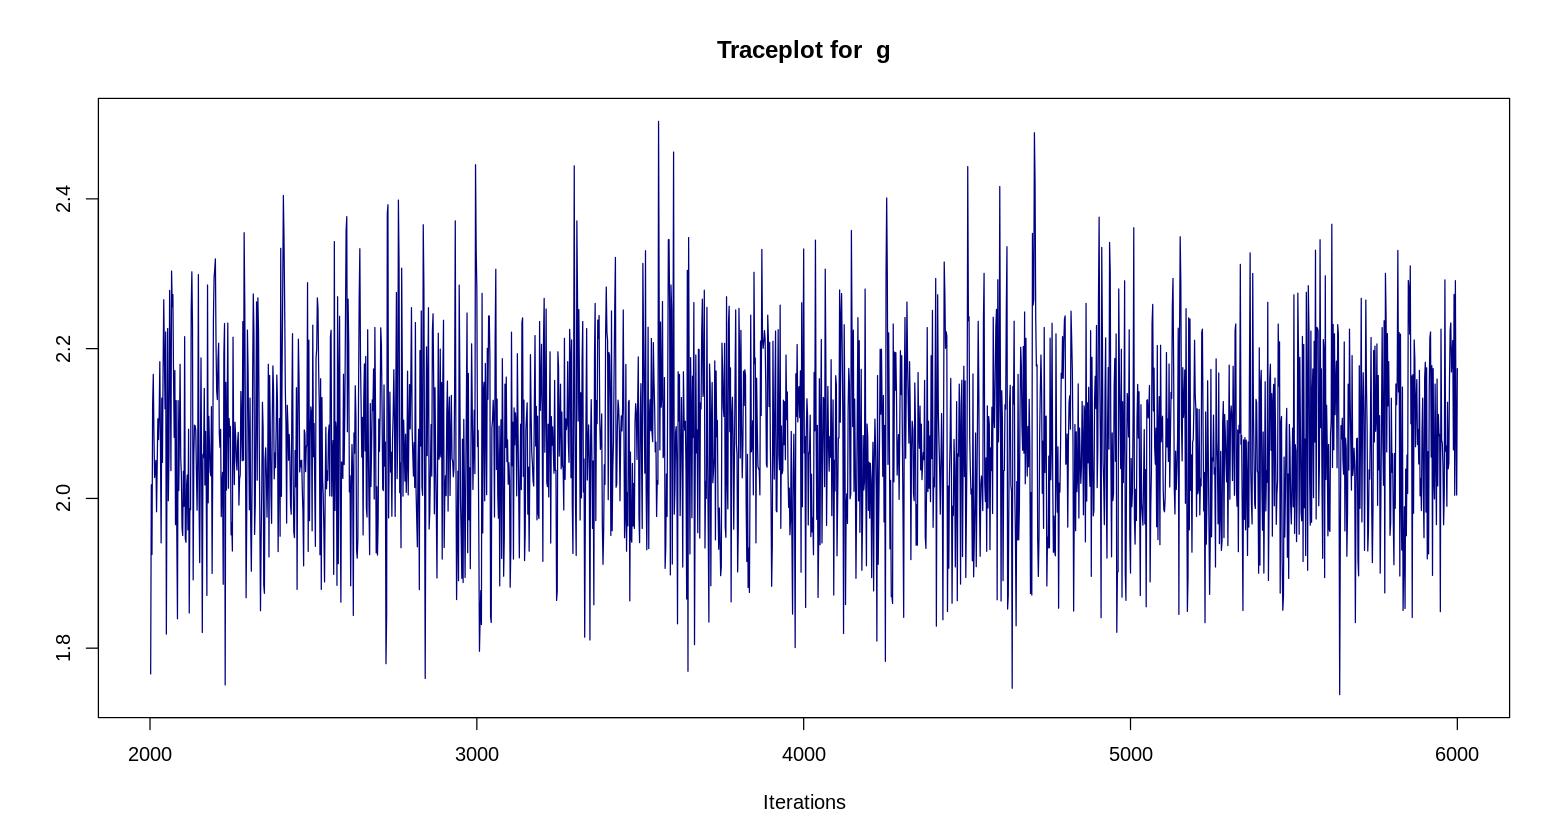

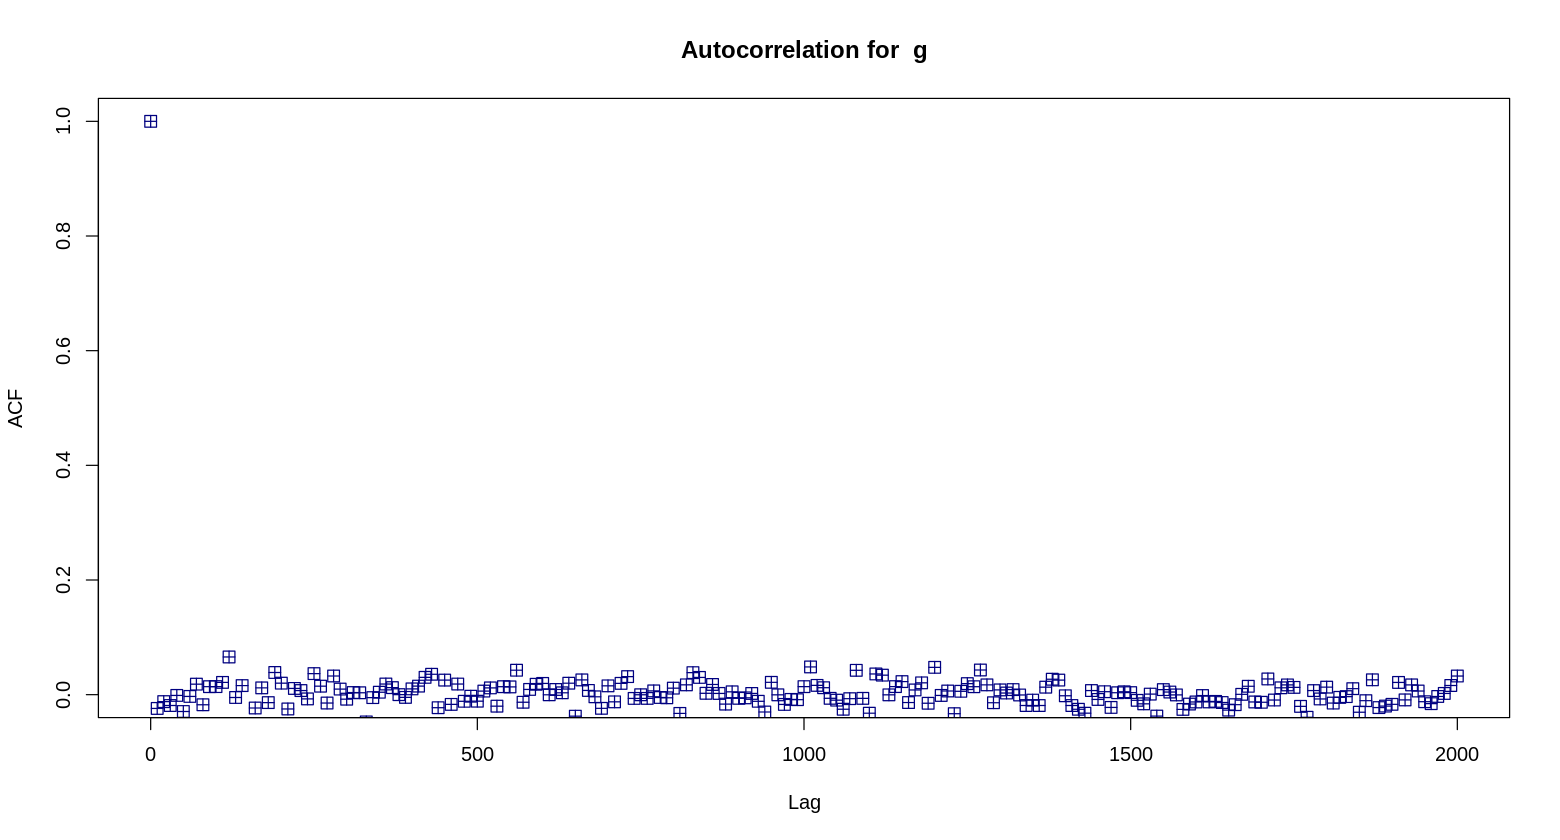

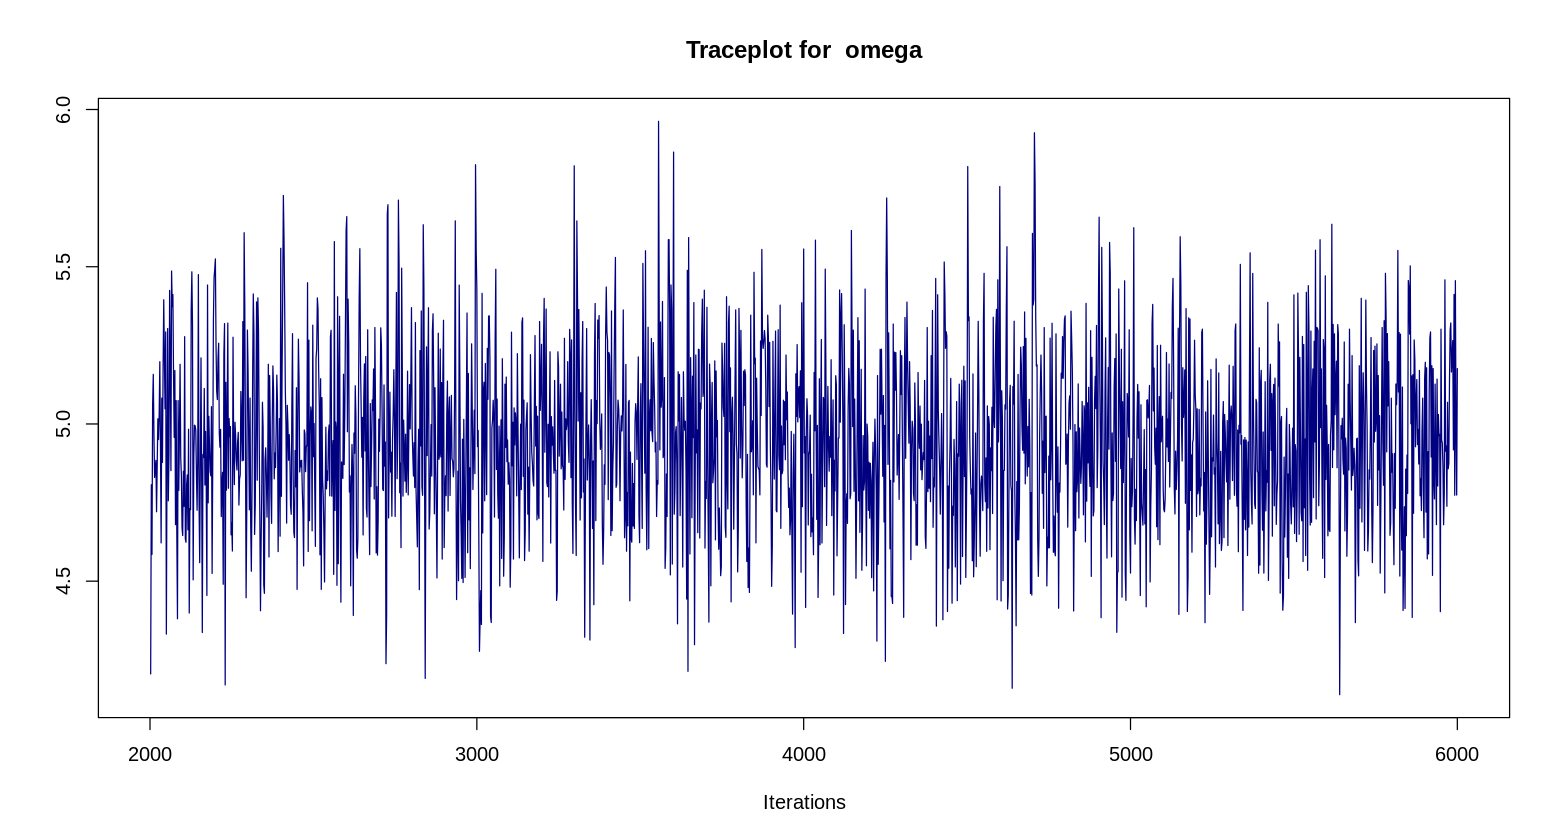

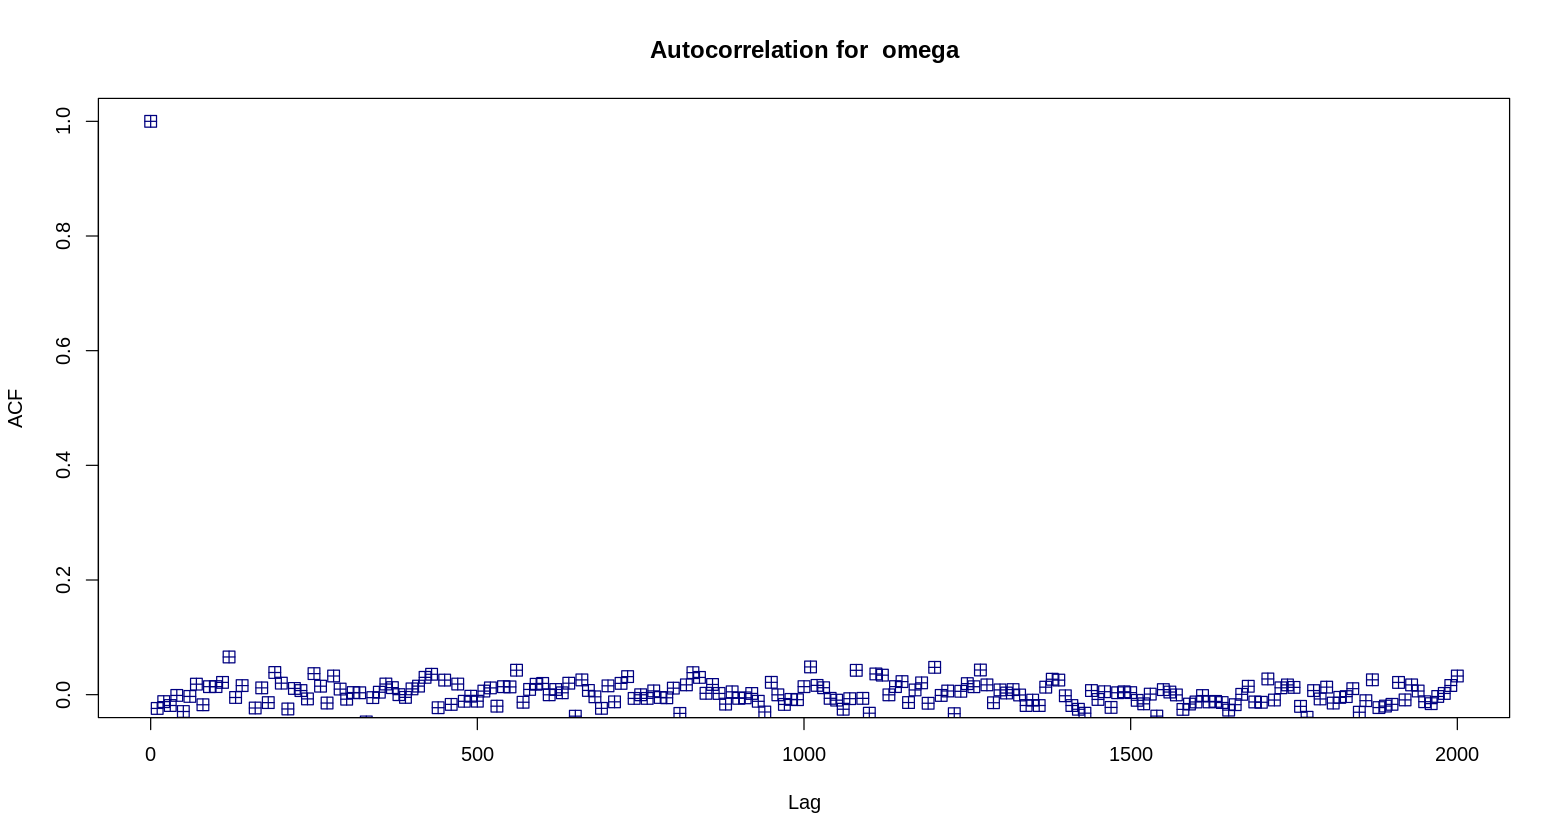

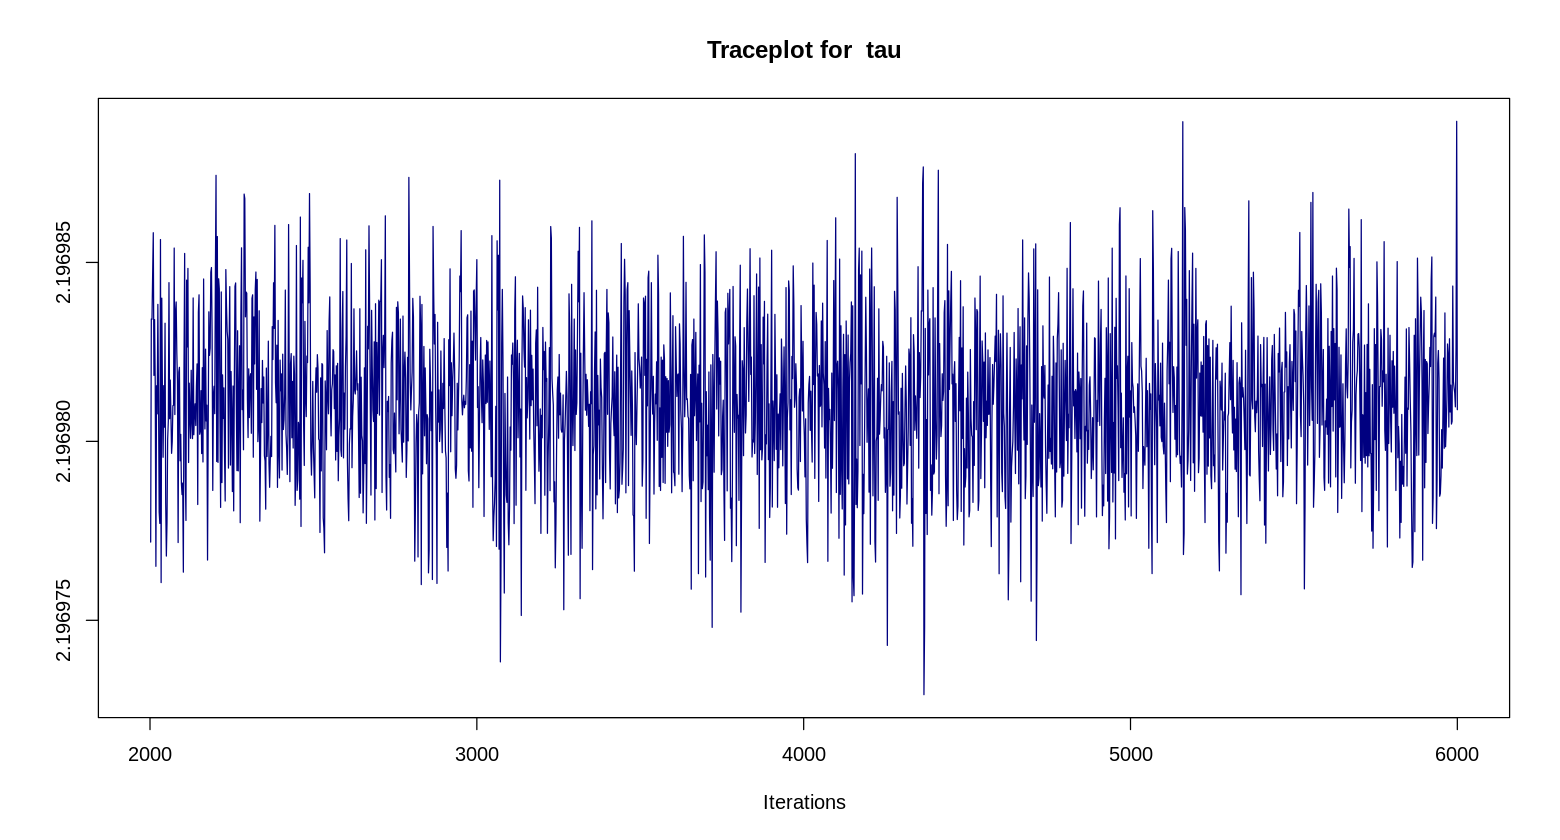

ERROR: Error in mapply(child_vp, vp_name = vpname(x$layout), t = .subset2(x$layout, : zero-length inputs cannot be mixed with those of non-zero length


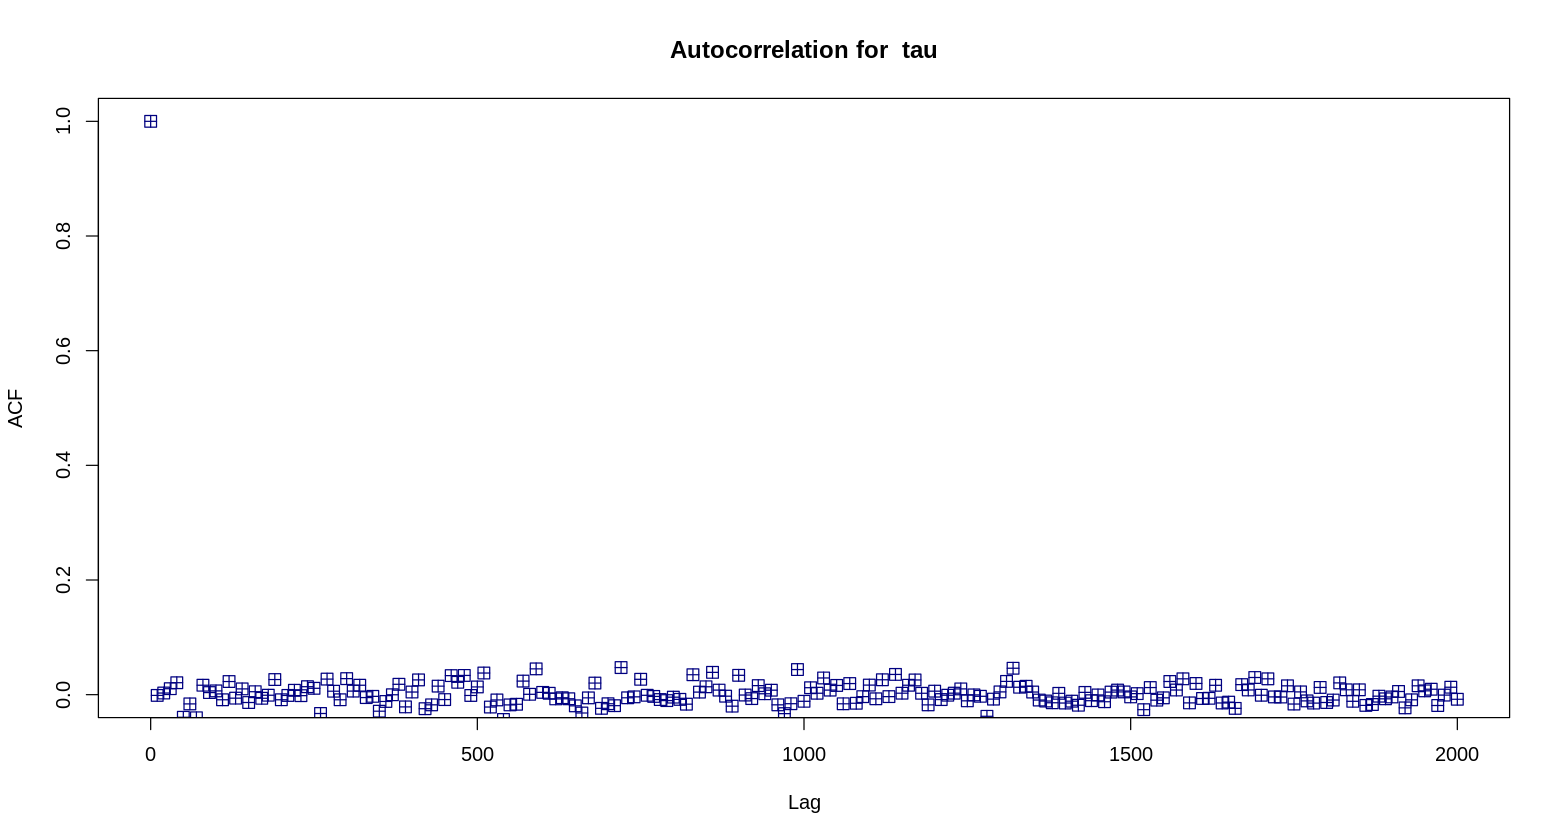

In [70]:
chain.plot(oscillation.chain)

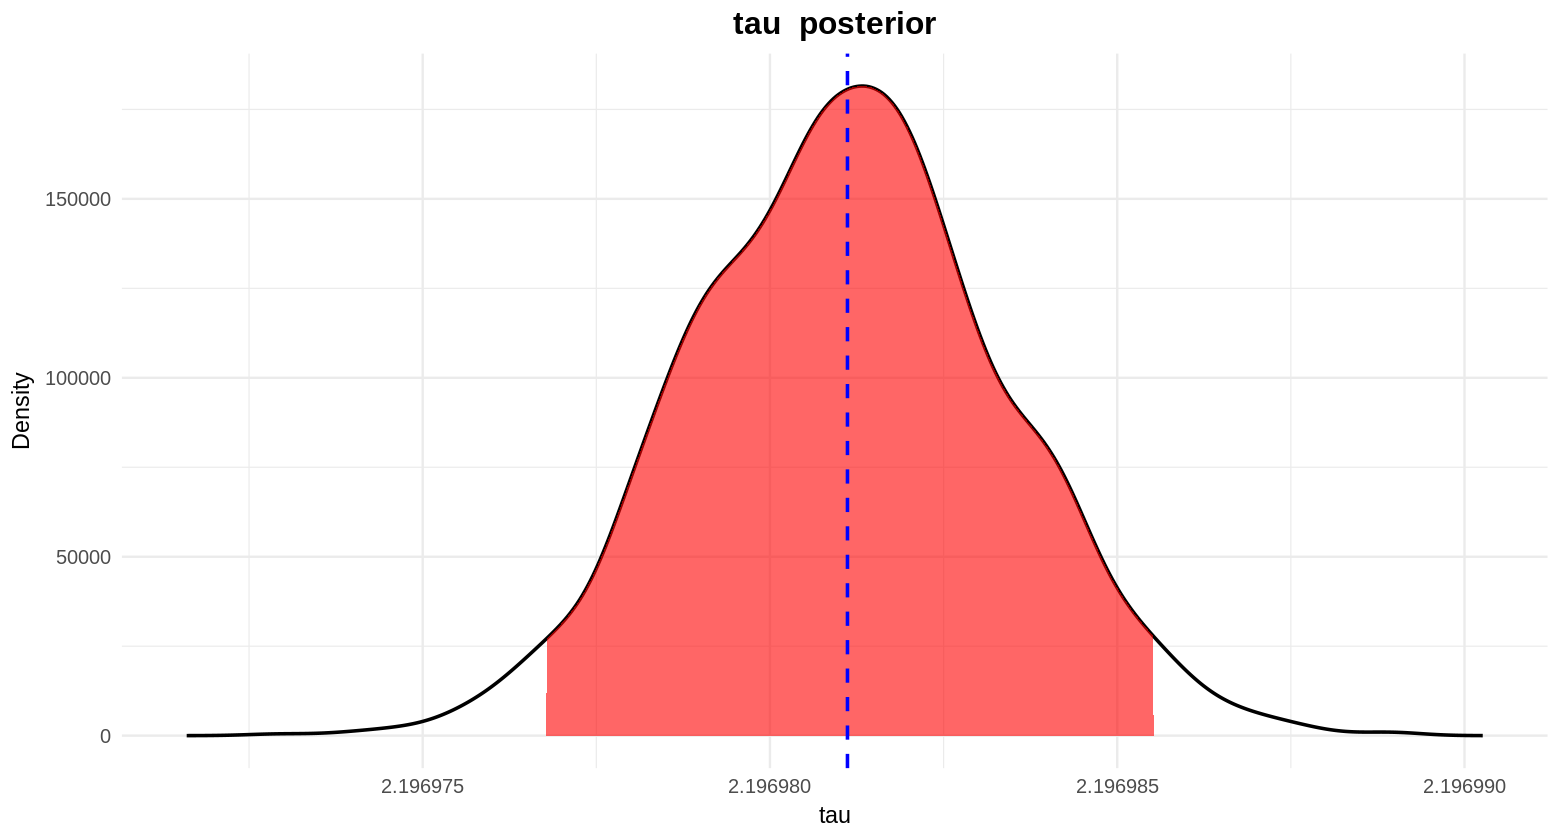

In [72]:
posterior.plot(oscillation.chain, param = 'tau')

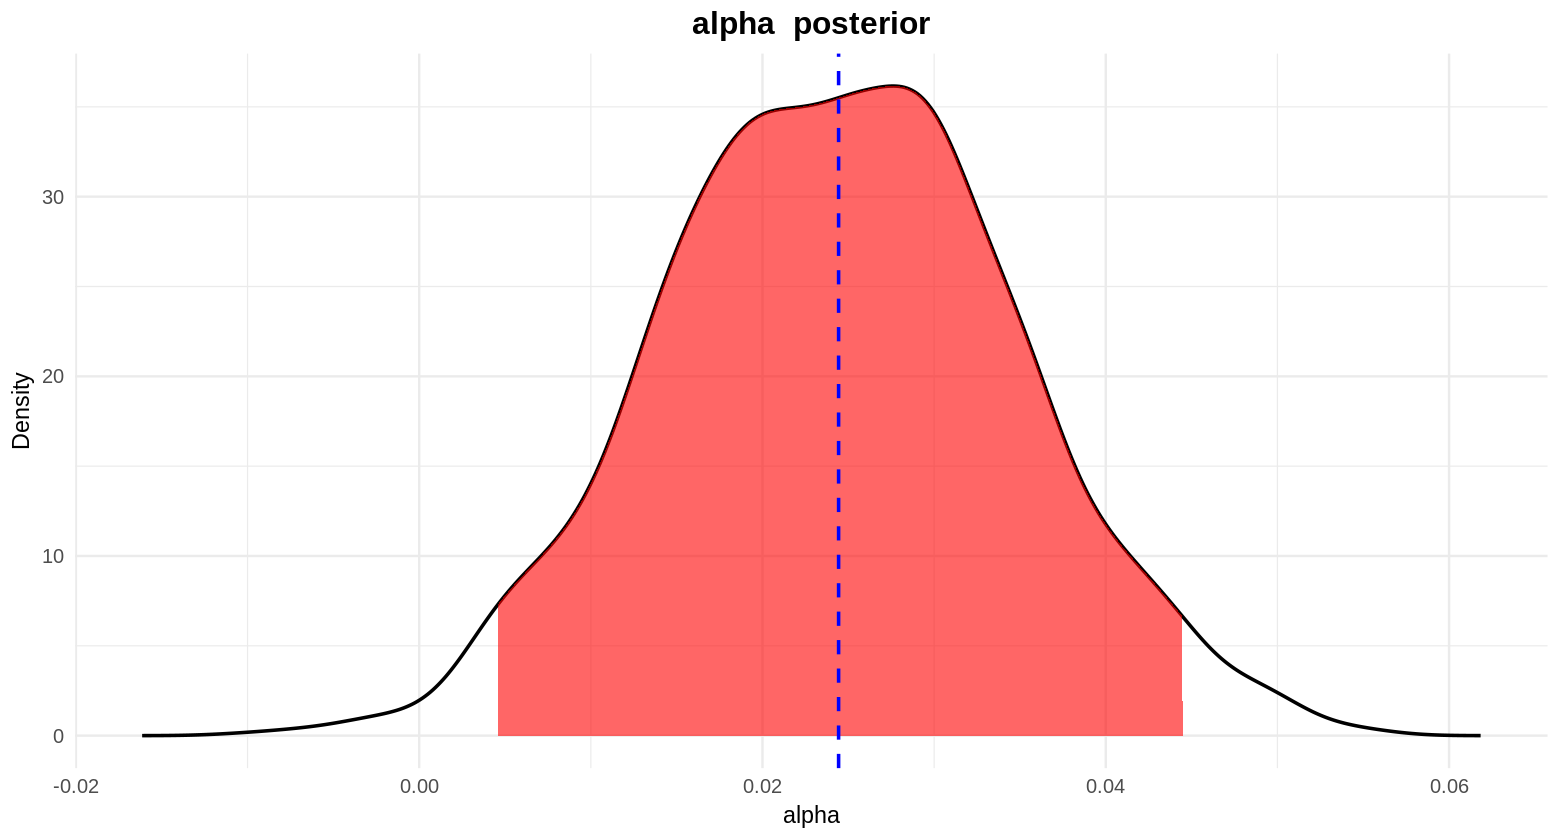

In [73]:
posterior.plot(oscillation.chain, param = 'alpha')

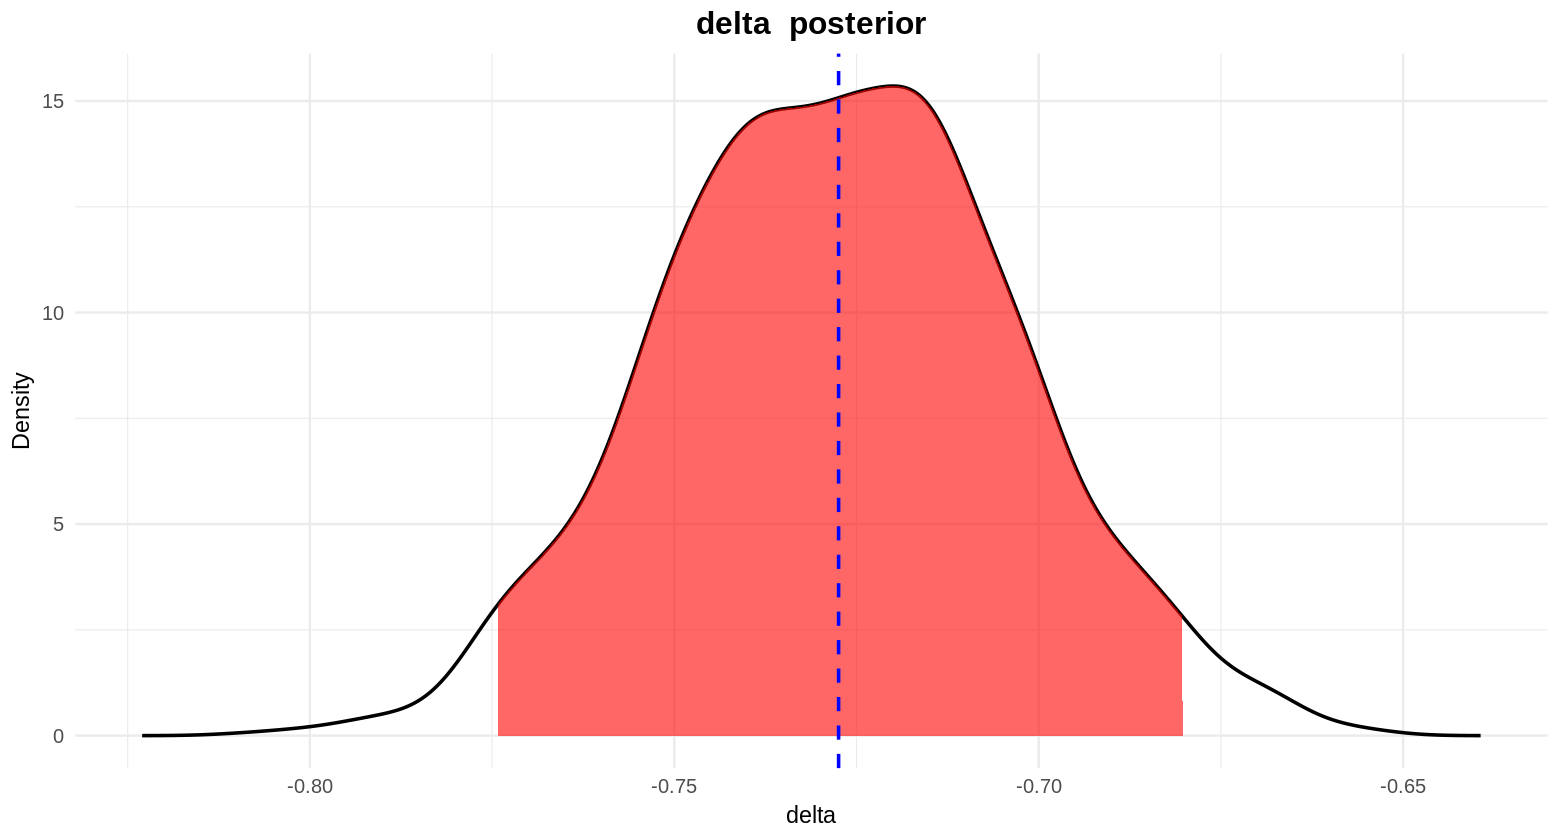

In [74]:
posterior.plot(oscillation.chain, param = 'delta')

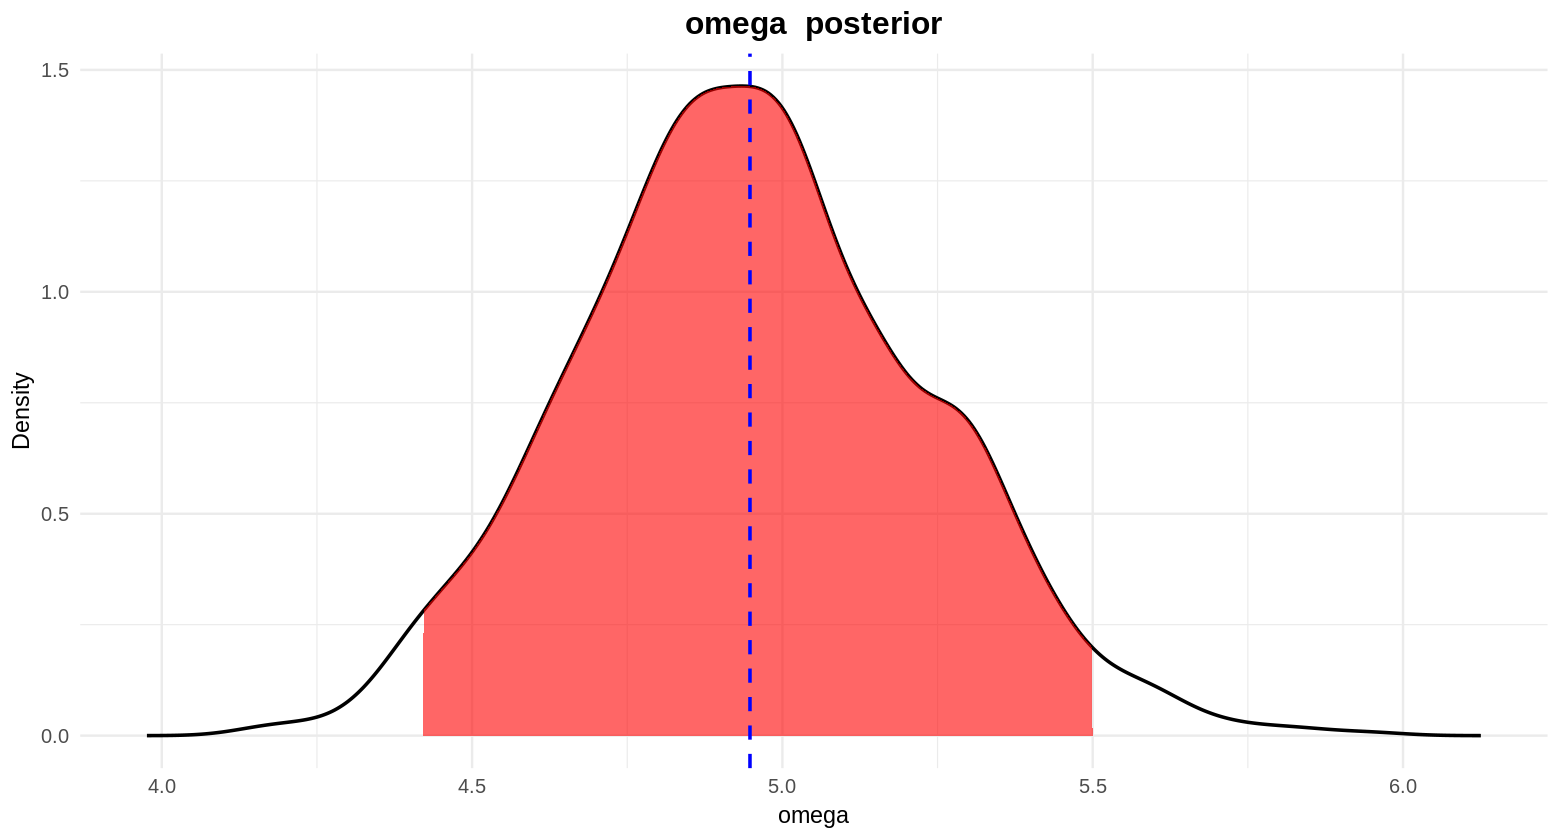

In [75]:
posterior.plot(oscillation.chain, param = 'omega')

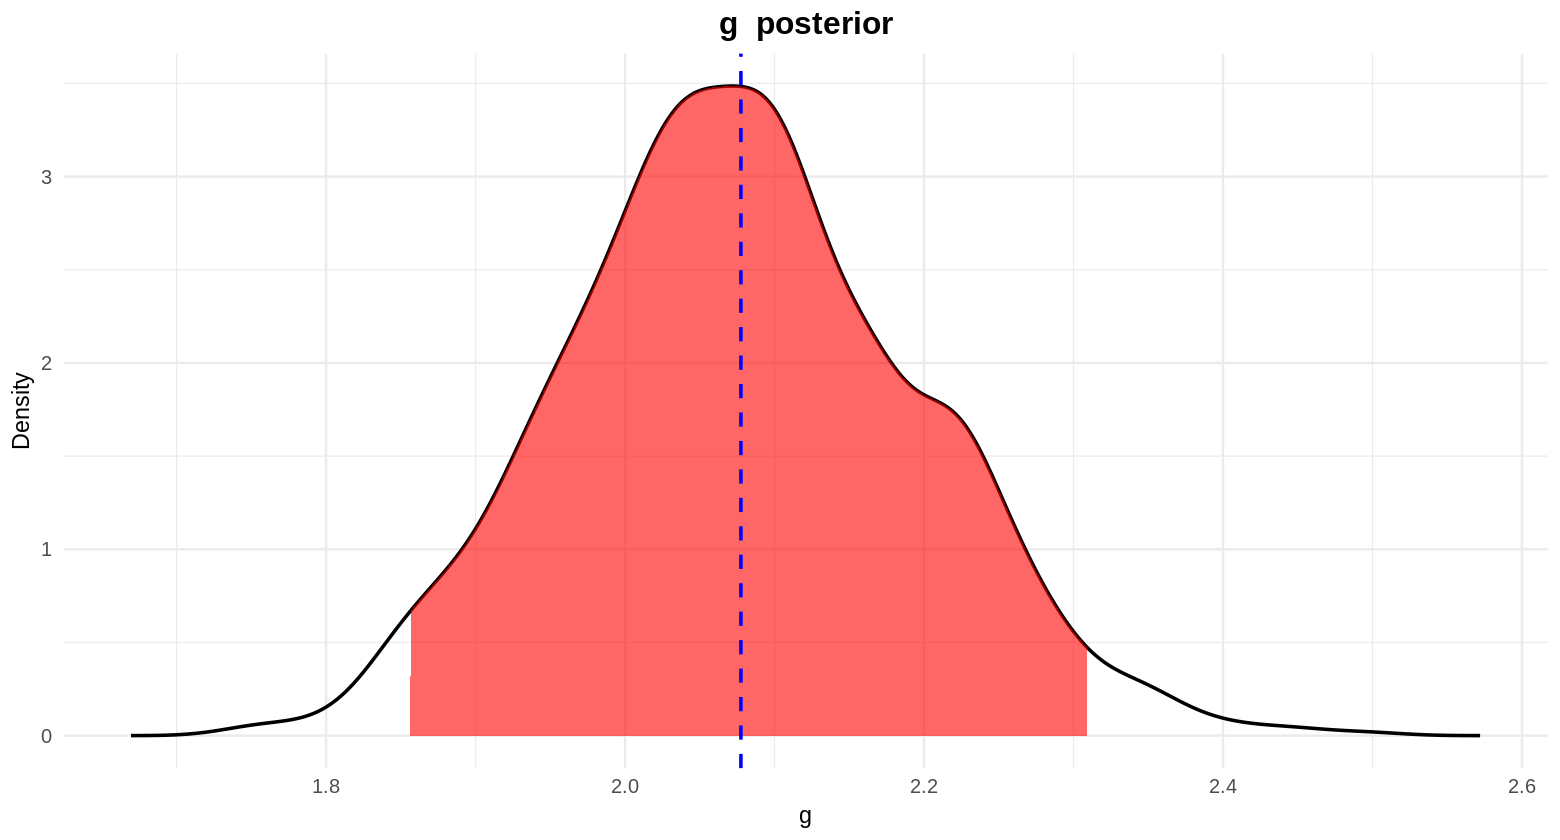

In [76]:
posterior.plot(oscillation.chain, param = 'g')

From the inference on the gyromagnetic ratio, we can conclude that using an unbinned analysis on our dataset places the expected value well within the 95% credibility interval of the fitted parameter.

## Bibliography 

<a href="pdg">[1]</a> Particle Data Group. "Muon (μ) Properties." 2020. https://pdg.lbl.gov/2020/listings/rpp2020-list-muon.pdf

<a href="delta">[2]</a> Blanchard, François. "Spark Chamber Report." McGill University, 2012. https://www.physics.mcgill.ca/~francois/projects/spark/Reports/201209_blanchard_spark.pdf

<a name="trick"></a>[3] Joseph, Léo. "Tricks for Epidemiology Research." McGill University. https://www.medicine.mcgill.ca/epidemiology/Joseph/courses/common/Tricks.html

<a name="capture"></a>[4] M. Eckhause, R.T. Siegel, R.E. Welsh, T.A. Filippas,
Muon capture rates in complex nuclei,
Nuclear Physics,
Volume 81, Issue 3,
1966,
Pages 575-584,
ISSN 0029-5582
https://doi.org/10.1016/0029-5582(66)90231-8

<a name="bosnar"></a>[5] Damir Bosnar, Mihael Makek, Zoran Matić; A simple setup for the determination of the cosmic muon magnetic moment. Am. J. Phys. 1 August 2022; 90 (8): 635–640. https://doi.org/10.1119/5.0077280

<a name="amsler"></a>[6] C. Amsler; The Determination of the Muon Magnetic Moment from Cosmic Rays. Am. J. Phys. 1 December 1974; 42 (12): 1067–1069. https://doi.org/10.1119/1.1987938

